# Self-Driving Car Engineer Nanodegree

## P2: Build a Traffic Sign Recognition Classifier | Deep Learning

### Data Exploration

#### Load and Setup Libraries

In [1]:
import cv2
import time
import pickle
import random
import itertools
import classifier

import numpy as np
import pandas as pd
import tensorflow as tf

from scipy import misc
from six.moves import xrange
from IPython.display import HTML
from moviepy.editor import VideoFileClip

%pylab
%matplotlib inline
plt.style.use('ggplot')

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


#### Loading the data

First of all, we load the data. The data set was stored on a couple of pickle files which are files containing Python objects that were converted into byte stream for more compact storage and serialization.

In [2]:
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
test.keys()

dict_keys(['features', 'sizes', 'labels', 'coords'])

In [4]:
train.keys()

dict_keys(['features', 'sizes', 'labels', 'coords'])

In [5]:
train['sizes']

array([[29, 30],
       [30, 30],
       [30, 30],
       ..., 
       [58, 62],
       [63, 69],
       [68, 69]], dtype=uint8)

In [6]:
train['coords']

array([[ 5,  6, 24, 25],
       [ 5,  5, 25, 25],
       [ 5,  5, 25, 25],
       ..., 
       [ 5,  6, 53, 57],
       [ 5,  7, 58, 63],
       [ 7,  6, 62, 63]], dtype=uint8)

We can see how the only keys we are interested on from these objects are features and labels. The `sizes` property describes the width and height the original image was. And the `coords` property describes the coordinates in which the traffic sign was on. However, these data set has been preprocessed for us. Therefore, we can just go ahead and use the `features` and `labels` provided.

#### Data Statistics

We can now breifly look into the other two properties to get a sense for the data set.

In [7]:
n_classes = len(np.unique(y_train))

n_train = X_train.shape[0]
n_test = X_test.shape[0]

image_shape = X_train[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


We can see almost 40k training samples, and over 10k test samples. This is about 75:25 split ratio for training and testing respectively. This is a fair split and we will continue with it.

Additionally, we can observe that each image is on a square of 32 pixels, and they are color images with 3 channels for Red, Green and Blue.

Finally, we have a total of 43 different types of traffic signs.

#### Visualize sample images

Let's now visualize a couple of samples.

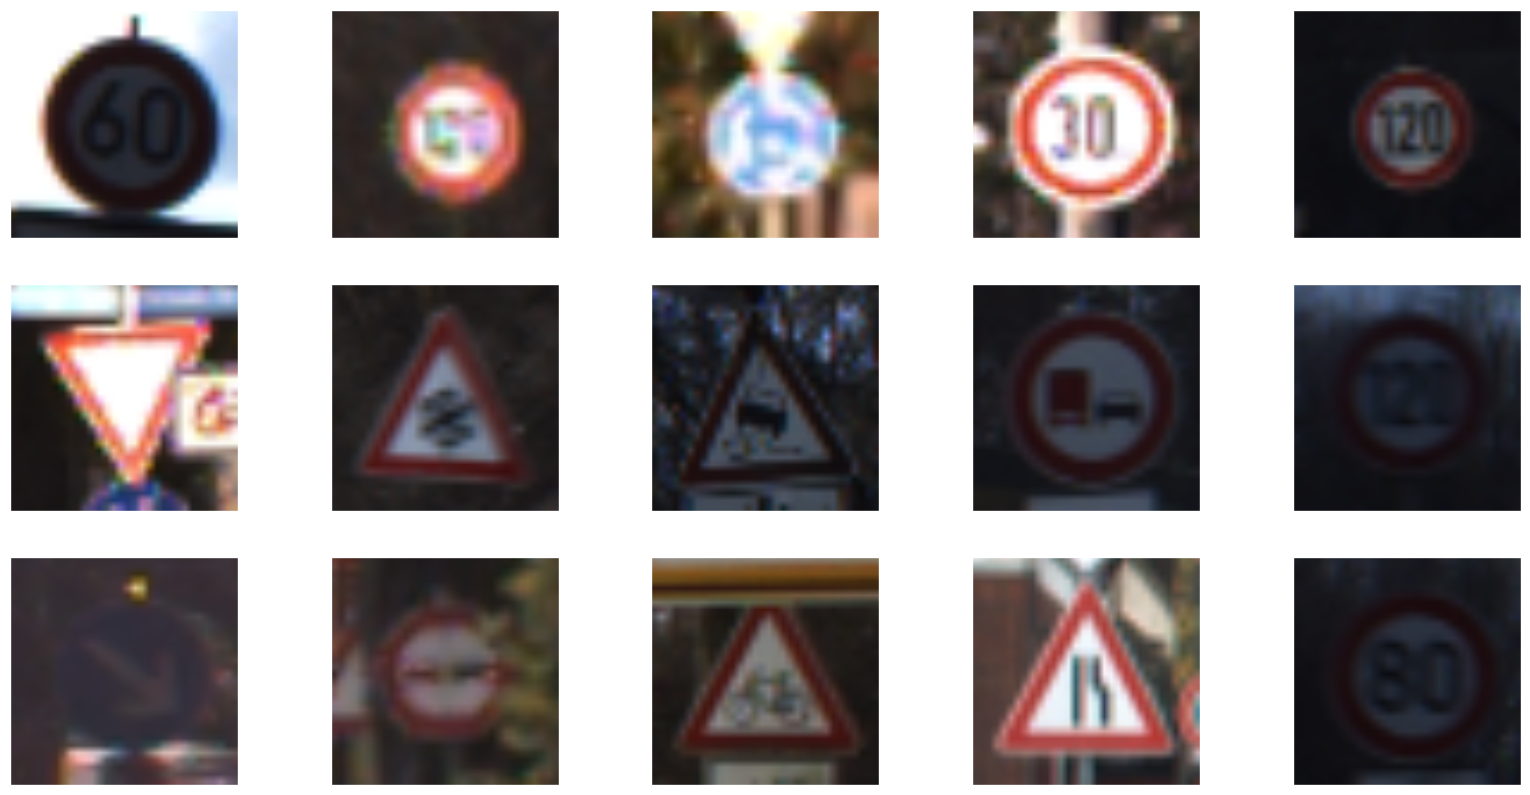

In [8]:
fig = plt.figure(figsize=(20,10))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(X_train[np.random.randint(n_train)])

It looks like a fair data set. Some of the images look crisp and clear, while other images look somewhat distorted. Some are blured, some are too dark, some were taken from an angle. However, since we will be implementing a convolutional neural network, these issues will be minimized during training. Also, we could implement an image augmentation pipeline that simulates some of these distrotions and train the data set to be robust enough to generalize these signs even in the worst conditions.

#### Image Class Distributions

Let's look into how many samples each class has:

(array([  210.,  2220.,  2250.,  1410.,  1980.,  1860.,   420.,  1440.,
         1410.,  1470.,  2010.,  1320.,  2100.,  2160.,   780.,   630.,
          420.,  1110.,  1200.,   210.,   360.,   330.,   390.,   510.,
          270.,  1500.,   600.,   240.,   540.,   270.,   450.,   780.,
          240.,   689.,   420.,  1200.,   390.,   210.,  2070.,   300.,
          360.,   240.,   240.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

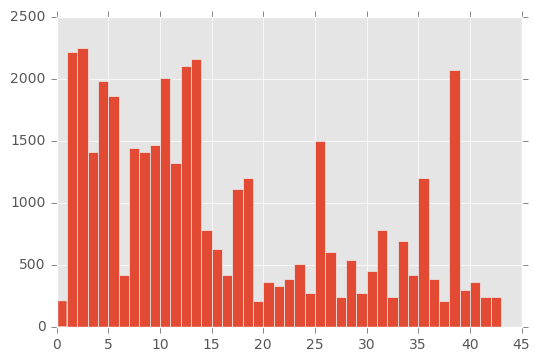

In [9]:
plt.hist(y_train, bins=range(n_classes + 1))

We can see how some of the traffic signs are under-represented. Some classes have a factor of 100 samples as many samples as other classes. This couple present a problem in which classes that have fewer samples have a lower chance of accurately generalizing on the testing data. 

Let's look into the samples on the test data set.

(array([  60.,  720.,  750.,  450.,  660.,  630.,  150.,  450.,  450.,
         480.,  660.,  420.,  690.,  720.,  270.,  210.,  150.,  360.,
         390.,   60.,   90.,   90.,  120.,  150.,   90.,  480.,  180.,
          60.,  150.,   90.,  150.,  270.,   60.,  210.,  120.,  390.,
         120.,   60.,  690.,   90.,   90.,   60.,   90.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

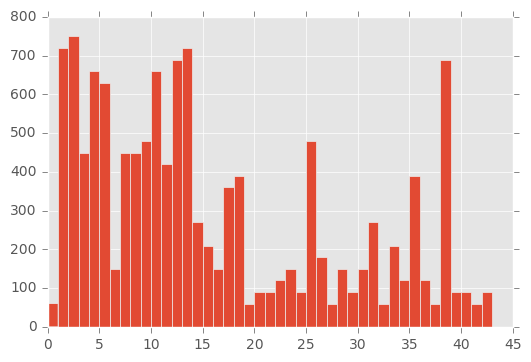

In [10]:
plt.hist(y_test, bins=range(n_classes + 1))

It look like the samples were split into train/test uniformly randomly as we can see a very similar trend on the test and train sets. Let's look a little more into the samples that are over vs under represented.

In [11]:
sign_strings = pd.read_csv('signnames.csv', index_col=0)
least_seen = [0,38,39,40,41,42]
most_seen = [1,2,4,5,12,13]

First let's look at sample images of those classes that have fewer samples.

In [12]:
sign_strings.loc[least_seen,:]

SignName
ClassId                                                   
0                                     Speed limit (20km/h)
38                                              Keep right
39                                               Keep left
40                                    Roundabout mandatory
41                                       End of no passing
42       End of no passing by vechiles over 3.5 metric ...

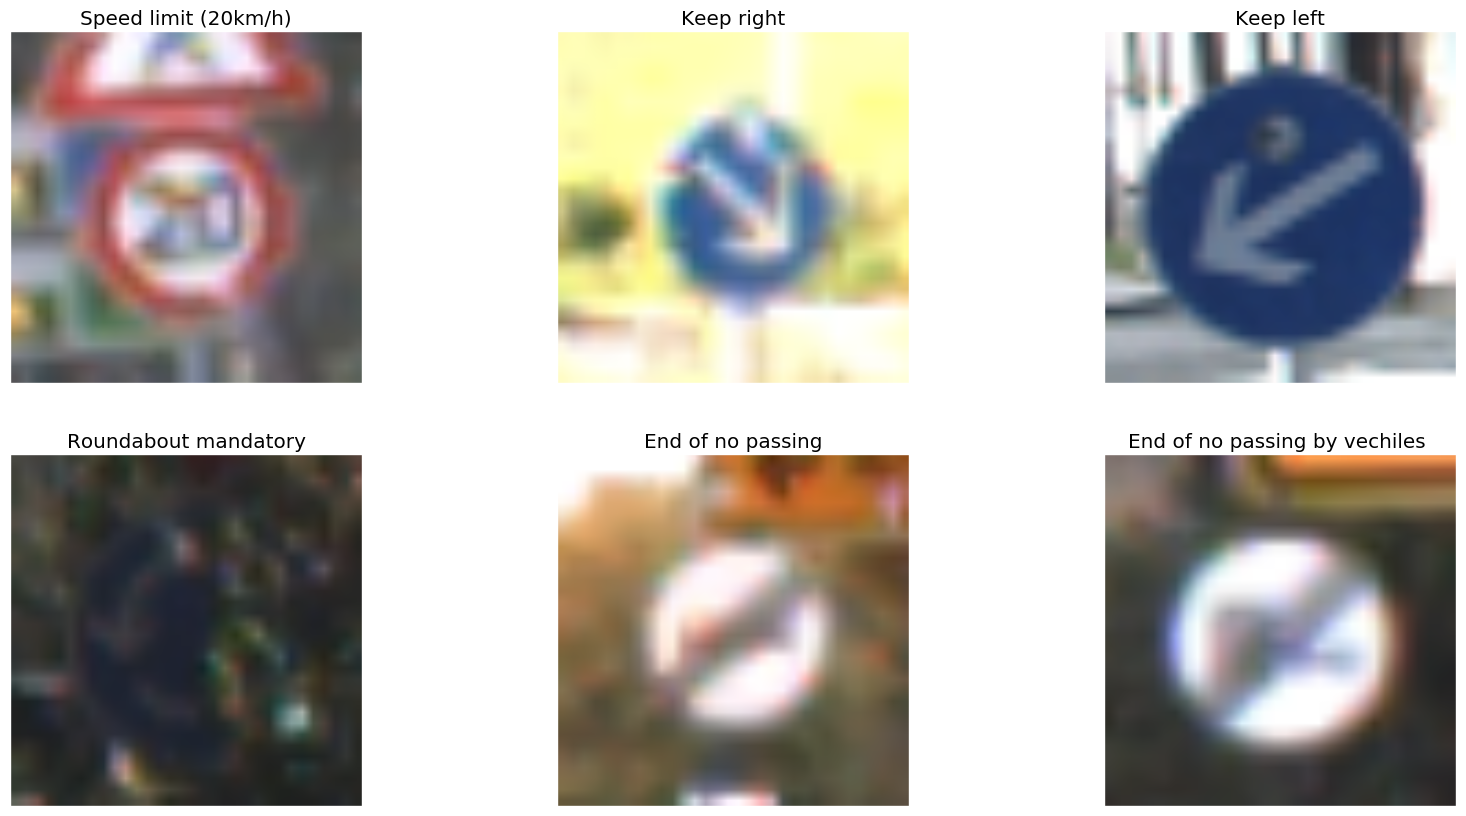

In [13]:
fig = plt.figure(figsize=(20,10))

for i, c in enumerate(least_seen):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.loc[c,'SignName'][:30])
    idx = np.squeeze(np.argwhere(y_train == c))[0]
    ax.imshow(X_train[idx])

Now, let's take a look at those classes that are more common on the data set.

In [14]:
sign_strings.loc[most_seen,:]

SignName
ClassId                      
1        Speed limit (30km/h)
2        Speed limit (50km/h)
4        Speed limit (70km/h)
5        Speed limit (80km/h)
12              Priority road
13                      Yield

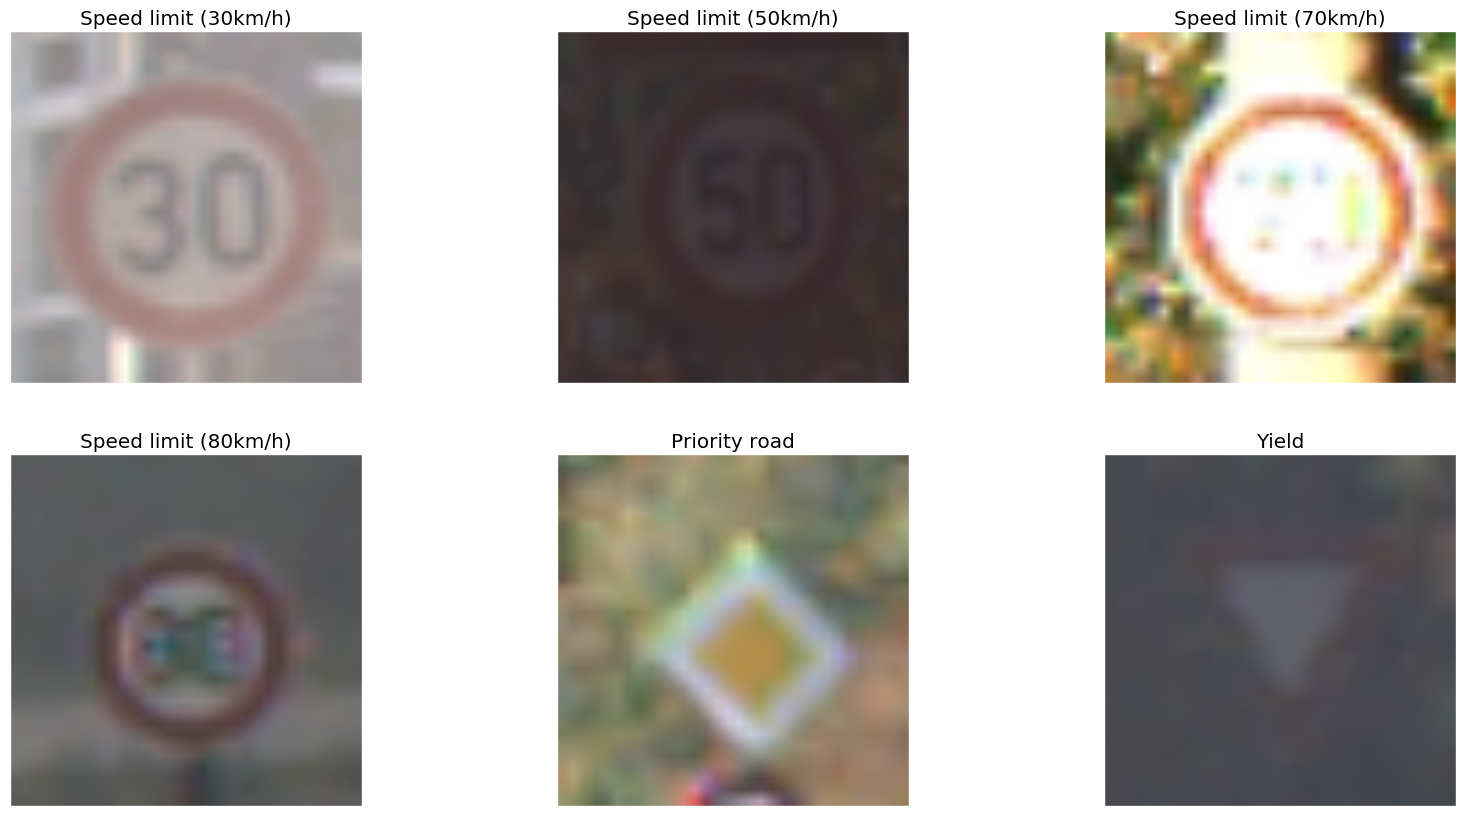

In [15]:
fig = plt.figure(figsize=(20,10))

for i, c in enumerate(most_seen):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.loc[c,'SignName'][:30])
    idx = np.squeeze(np.argwhere(y_train == c))[0]
    ax.imshow(X_train[idx])

We can observe the traffic signs that are under represented as the 20km limit, keep right and left, roundabout and so on. While the over represent being the common speed limits, priority road and yield.

Later, we will attempt to artificially generate augmented images from the original data set. Also, we will be selecting a validation set with equal amount of samples per class to ensure robust training.

#### Mean and Std images

One interesting visualization we can look into is the average, and standard deviation image. The mean image would tell us how would an image that represents all images looks like. The standard deviation image would tell us where in the images are changes likely to happen. Finally, we will relate these with each other and visualize where and how much variance is in the mean representation of the traffic sign.

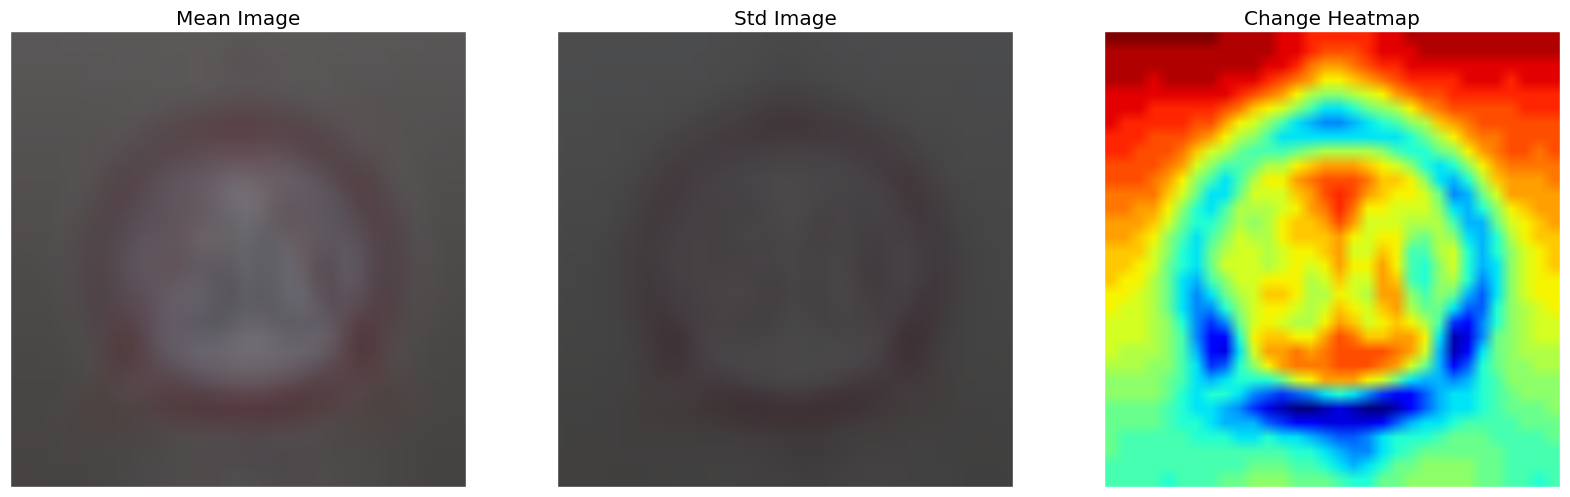

In [16]:
mean_img = np.mean(X_train, axis=0)
std_img = np.std(X_train, axis=0)
heat_img = np.mean(std_img, axis=2)

fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1, 3, 1)
ax1.grid(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.set_title('Mean Image')
ax1.imshow(mean_img.astype(np.uint8))

ax2 = fig.add_subplot(1, 3, 2)
ax2.grid(False)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax2.set_title('Std Image')
ax2.imshow(std_img.astype(np.uint8))

ax3 = fig.add_subplot(1, 3, 3)
ax3.grid(False)
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax3.imshow(std_img.astype(np.uint8))
ax3.set_title('Change Heatmap')
ax3.imshow(heat_img.astype(np.uint8))

It is very interesting to see these images. The left tells us how does the blended image of all images look like. We can assume that the number of speed limit images are far greater than others since the blended image looks very much like one of those.

The image on the right tells us, on average, how much each color channel will change as a heat map. The more red the more likely our mean image is different from the each image, and the more blue, the more likely our mean image accurately represents any given image.

The point of these explorations is because machine learning is about building models that understand invariances. We need our model to be able to generalize unseen data. By modeling the mean and the standard deviation of the dataset, we are able to understand what our model should be able to generalize properly.

Given these visualizations we could assume that whitening the images or normalizing them could probably be beneficial. This process consists of removing the mean and the standard deviation from the images keeping a dataset that only contains the variations of the data. This would be a simple operation such as substracting the mean and dividing by the standard deviation.

Let's visualize what this image normalization process looks like. 

In [17]:
flattened = X_train.ravel()
flattened[:50]

array([ 75,  78,  80,  74,  76,  78,  83,  84,  83, 101,  92,  85, 130,
       107, 102, 153, 113, 114, 173, 114, 117, 188, 124, 124, 190, 151,
       150, 243, 228, 230, 255, 250, 255, 243, 239, 255, 232, 235, 255,
       170, 180, 212, 127, 146, 182, 124, 153, 175, 156, 181], dtype=uint8)

We can further explore the images by visualizing the distribution or range of frequency of possible values are. This would tell us whether the data is predictable or not by pointing things that would happen more than anything else. If there is, a Neural Network would be able to take advantage of it.

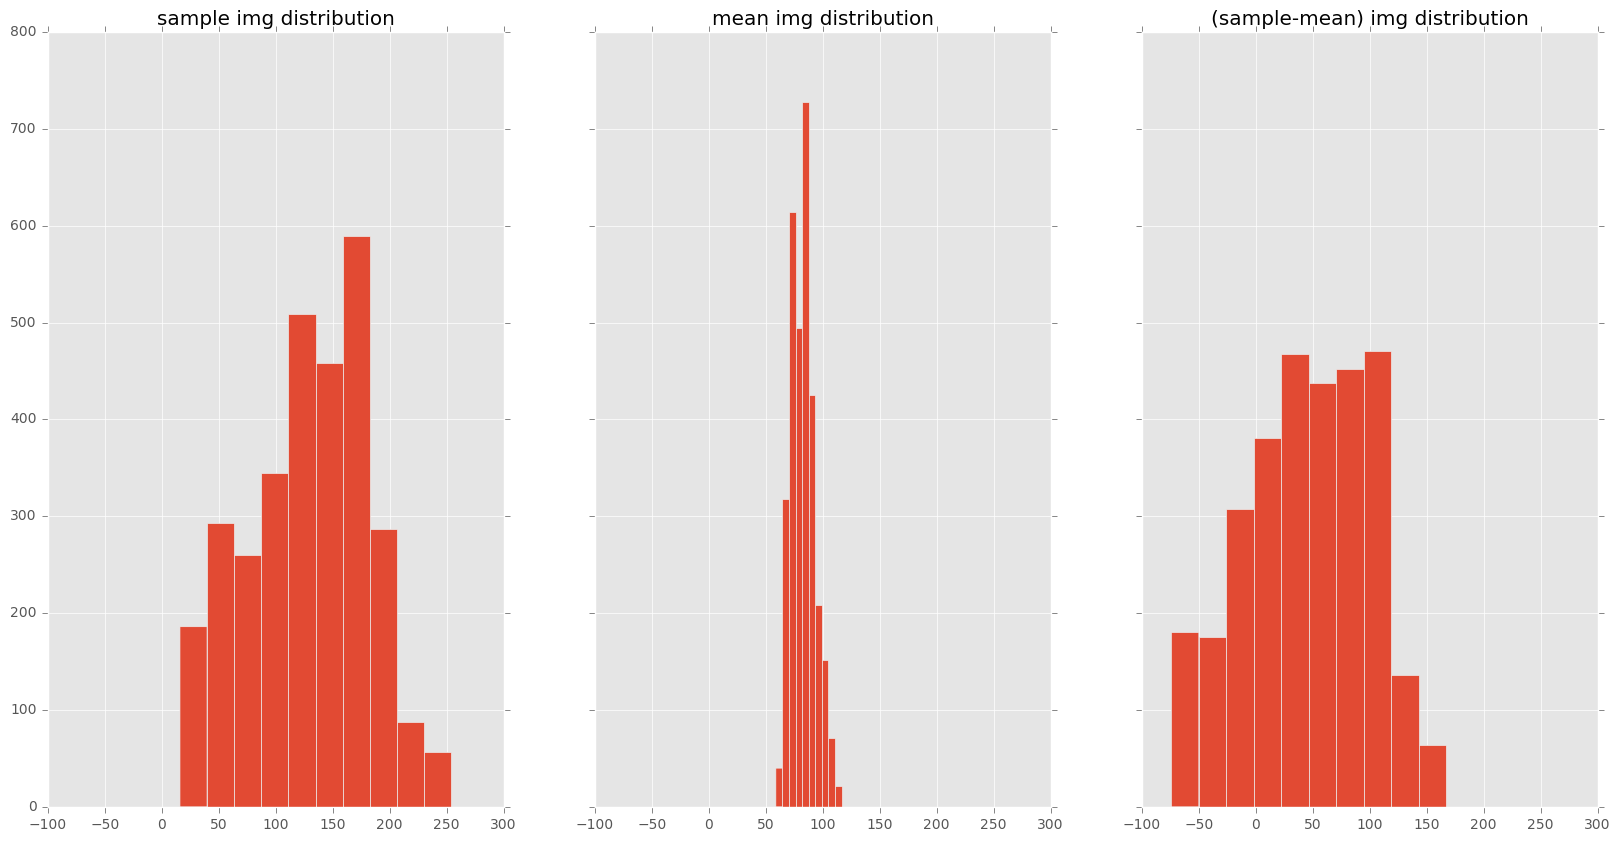

In [18]:
bins = 10
img = X_train[100]

fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharey=True, sharex=True)
axs[0].hist(img.ravel(), bins)
axs[0].set_title('sample img distribution')
axs[1].hist(mean_img.ravel(), bins)
axs[1].set_title('mean img distribution')
axs[2].hist((img-mean_img).ravel(), bins)
axs[2].set_title('(sample-mean) img distribution')

From the graph we can see the number of pixels intensity distribution, the mean image distribution around 80 and then the normalized image showing the number of pixels that were above and below the mean for this particular image.

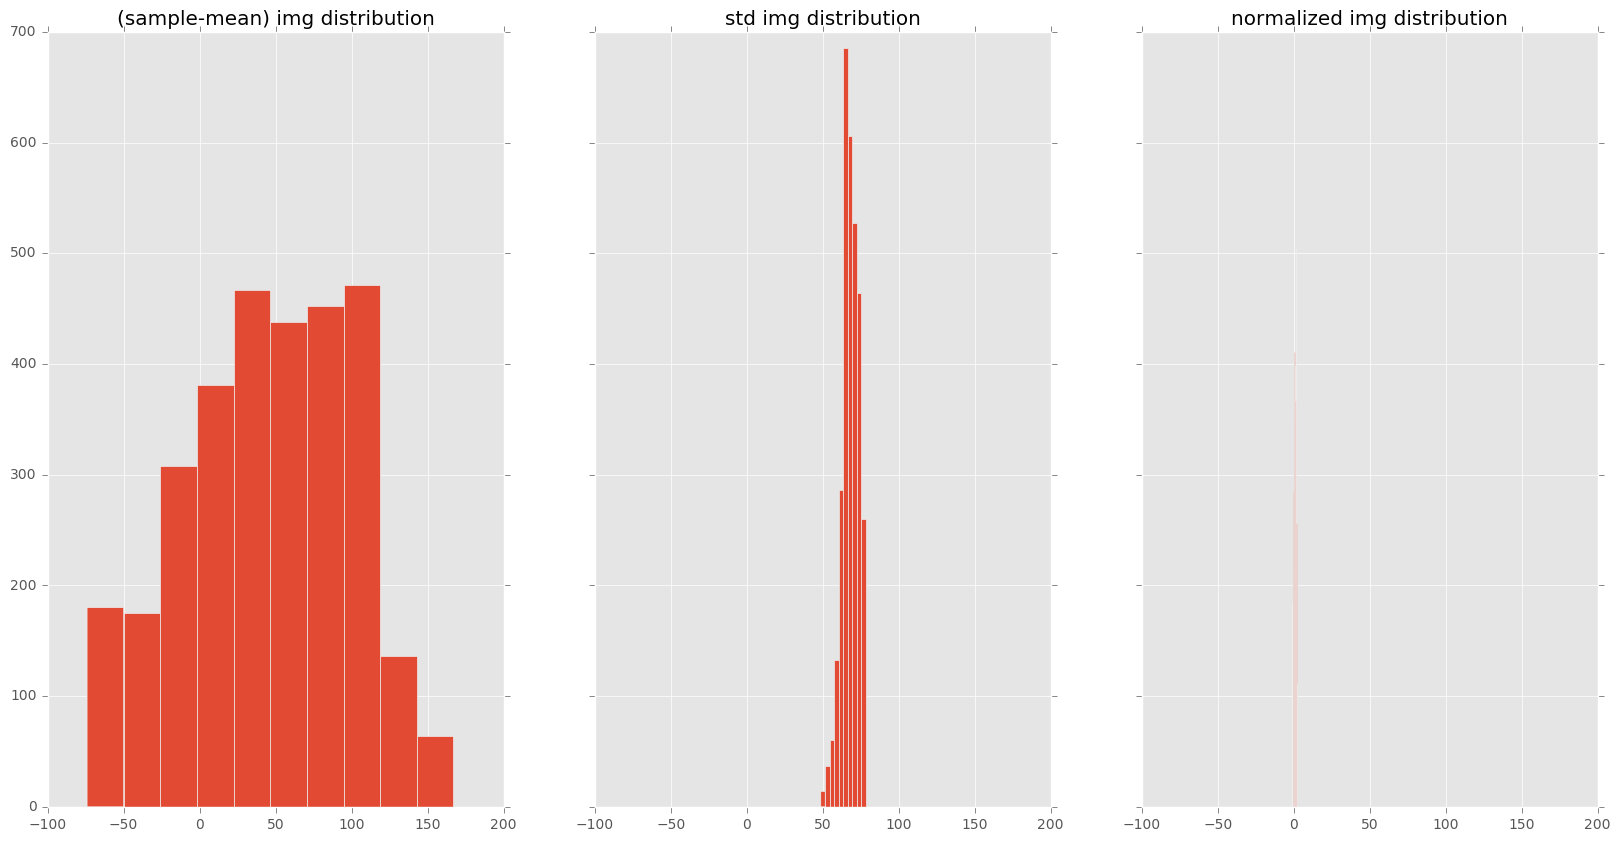

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharey=True, sharex=True)
axs[0].hist((img-mean_img).ravel(), bins)
axs[0].set_title('(sample-mean) img distribution')
axs[1].hist(std_img.ravel(), bins)
axs[1].set_title('std img distribution')
axs[2].hist(((img-mean_img)/std_img).ravel(), bins)
axs[2].set_title('normalized img distribution')

Next we divide this centered image by the standard deviation image to normalize it. On the right, we can hardly see the normalized values, but let's zoom in to be able to better identify the distribution.

(array([ 184.,  209.,  284.,  345.,  411.,  399.,  367.,  505.,  256.,  112.]),
 array([-0.97876036, -0.65657365, -0.33438693, -0.01220021,  0.3099865 ,
         0.63217322,  0.95435994,  1.27654665,  1.59873337,  1.92092009,
         2.2431068 ]),
 <a list of 10 Patch objects>)

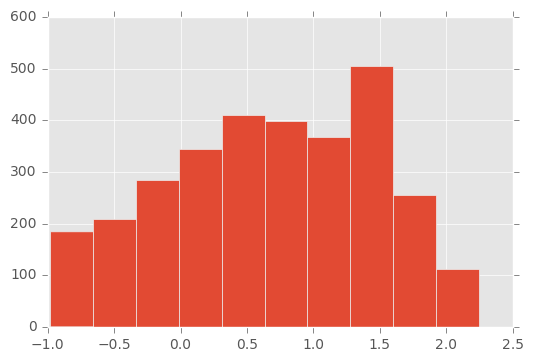

In [20]:
plt.hist(((img-mean_img)/std_img).ravel(), bins)

By normalizing the dataset, all the values would tend to be around 0 and on a smaller range, in this case from -2 to 2. This could turn into better calculations accuracies and performance speed gains. We will later pre-process the data set to include image normalization.

That's good for the visualizations so far. Let's now look at how we approached this problem and the solution we came up with.

### Model Design

We implemented several models. Interestingly, the best models were those who were feed the raw image instead of augmented data. We will show a few graphs of the overall design, the data augmentation we attempted and sample code of the final implementation.

For the code we ran trained the final model, make sure to check the file `classifier.py` next to this project.

#### Overall Design

To solve this problem, we used a convolutional neural network consisting of 2 convolutions each with pooling and local response normalization but on opposite sequence. On the classifier layer, we added a 3 layer neural netwok with a dropout layer right before the read out layer. With 384, 192 and 43 neural units in each layer respectively. The first and second layers had relu units, then these were feed into a drop out layer with 40% probability and this was connected to a softmax linear which was then normalize to get probabilities.

The following graphs are visualization from TensorBoard.

<img src="imgs/overall-architecture.png?dummy=8484744" />

Let's look into more detail at each of the steps of the CNN graph.

#### Images Preprocessing Pipeline 

As mentioned above, at first we augmented the data online during training, also called realtime augmentation. This allowed us to combine the image rescaling and augmentation into a single process, thus using the power of the GPU and CPU at the same time. We augmented the images on the CPU and processed the training on the GPU.

However, during training the best performance was achieved by a model that was fed 100% raw images. We are uncertain as to why this was, it could have been that the color of some of these signs actually helped with training, it could also be that the data augmentation process we created was too agressively modifying the images, or maybe that the CNN could have been better architected for grayscale images. In any case, it would be a matter of time in order to find the causes, fix the issues and obtain better results.

In any case, we will look at the data augmentation pipeline that we could later use to improve the model regardless of it having been utilized by our final model.

The following are the functions used for image augmentation.

In [21]:
def augment_image(img):
    img = tf.random_crop(img, [28, 28, 3])
    img = tf.image.random_hue(img, 0.25)
    img = tf.image.random_saturation(img, lower=0, upper=10)
    img = tf.image.random_brightness(img, max_delta=0.8)
    img = tf.image.random_contrast(img, lower=0, upper=10)
    img = tf.image.per_image_whitening(img)
    return img
    
def augment_images(images):
    _, img_height, img_width, _ = images.get_shape().as_list()
    images = tf.map_fn(lambda img: augment_image(img), images)
    images = tf.image.rgb_to_grayscale(images)
    images = tf.image.resize_images(images, img_height, img_width,
                                    method=0,
                                    align_corners=False)
    return images

We can see here random crops, color saturation, brightness and contrast, then image whitening and finally color image to grayscale transform and finally resizing the batch of all images back to the 32x32 the CNN was initially designed for before feeding the batch for training.

Let's now visulize these operations on some randomly selected images.

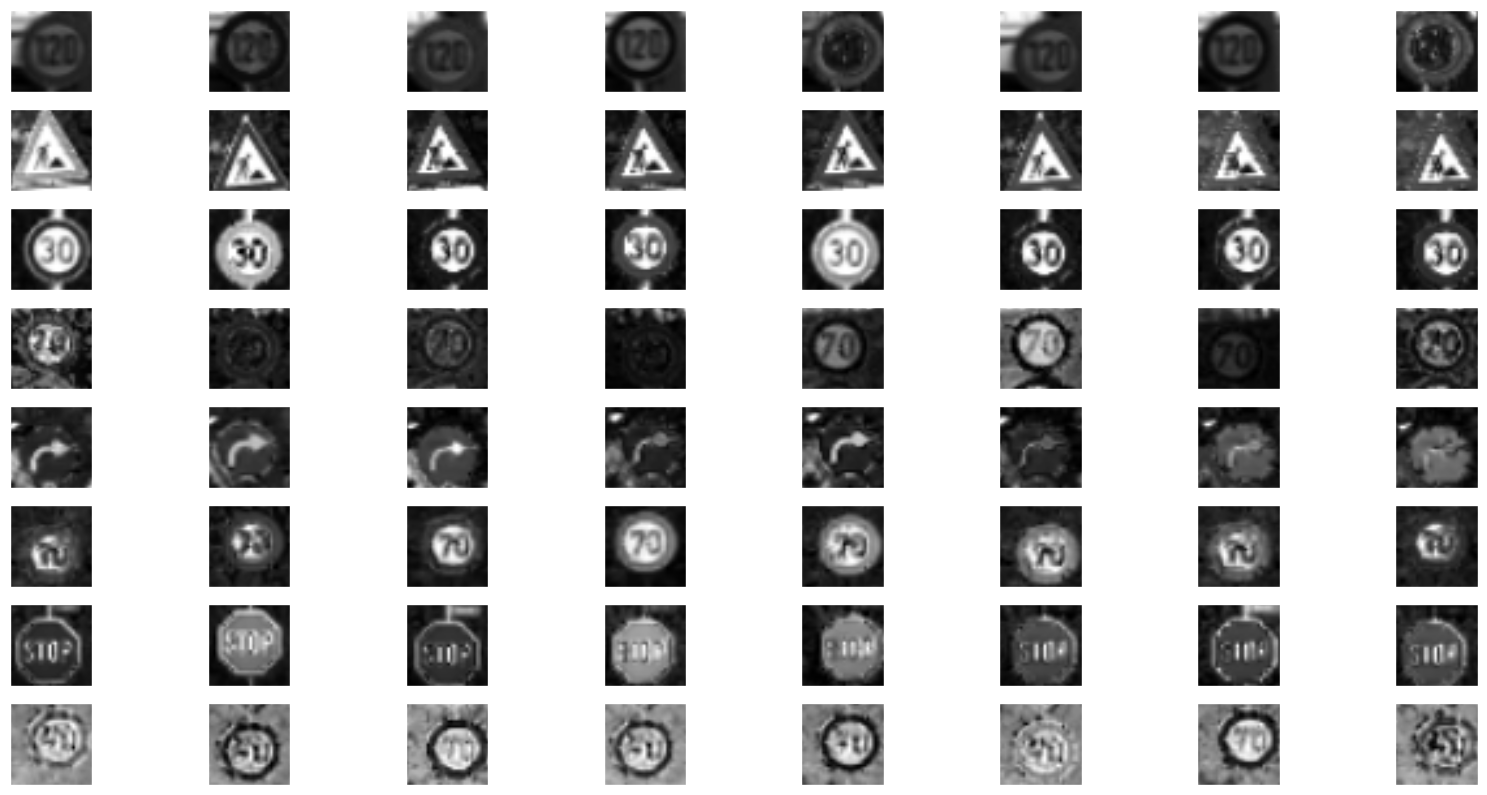

In [22]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        img = X_train[np.random.randint(n_train)]
        imgs = []
        orgs = []
        for i in range(64):
            if i % 8 == 0 :
                img = X_train[np.random.randint(n_train)]
                orgs.append(img)
            imgs.append(img)
        img_placeholder = tf.placeholder(tf.float32, shape=[64, 32, 32, 3])
        images = augment_images(img_placeholder)
        images = sess.run(images, feed_dict={img_placeholder:imgs})
        
        fig = plt.figure(figsize=(20,10))
        for i in range(64):
            ax = fig.add_subplot(8, 8, i + 1)
            ax.grid(False)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.imshow(np.squeeze(images[i]), cmap='gray')

Each of the rows above are the same exact image randomly transformed through the pipeline. We had decided not to add other augmentation methods such as flips because the likelihood of encountering a fliped sign on the real world is low. And more importantly, actually flipping the sign could change the class of a given sign. For example, a "Keep Right" sign flipped would be identical to a "Keep Left" while maintaining the original label. This would be a big issue for training.

This image augmentation pipeline could be later utilized to improve the accuracy of the model. But for now, let's look at what actually got into the final model.

#### Convolutions And Poolings

The following figure shows the convolutions in a close-up.

<img src="imgs/convolutions.png?dummy=8484744" />

As mentioned before, we pass the batch of images through a total of 2 convolutions. The first convolution with a 5 by 5 kernel changes the batches from a 3 to 64 channels. The convolution passes on a 1 by 1 stride with 'same' padding on top of a relu activation.

The result of this convolution gets pooled with a window of (1,2,2,1) for the [batch, height, width, channels] respectively and a kernel size of (1,3,3,1). This gets the max value of each window and reduces the two inner dimensions of the tensor, resulting on a 16x16 image with 64 channels.

Next, these pooling values get normalized through a local response normalization which is used to improve the values of the gradients in an attempt to gain speed in training, specially for Stochastic Gradient Descent.

We then use the same convolution configuration as the first, but on the 16x16x64 batch. We then normalize again and pool to obtain a 8x8x64.

So far the batches get modified as follows:

    images (?, 32, 32, 3)
    conv1 (?, 32, 32, 64)
    pool1 (?, 16, 16, 64)
    norm1 (?, 16, 16, 64)
    conv2 (?, 16, 16, 64)
    norm2 (?, 16, 16, 64)
    pool2 (?, 8, 8, 64)

#### Neural Network Classifier Architecture

On the classifier layers we pass the values coming from the convolutions and train the network on these features. We pass though 2 layers before a dropout layer and a final read outs.

Let's look into these in more detail.

<img src="imgs/fully-connected-neural-network.png?dummy=8484744" />

So we feed the batches coming from the convolutions, pooling and normalizations described above into the input layer of the neural network classifier. The batch coming from the convolutions is of 8 by 8 by 64. We take all of these values and flatten them into a 4096 values array. So the input layer of the neural network will input 4096 values thought relu neurons and output 384 resulting values.

These resulting values from the input layer will become the input of the hidden layer. Consisting of 384 input values and passing thought relu activation neurons, the hidden layer will further reduce the nodes to 192 values. These will get filtered through a dropout layer to reduce the chance of overfitting.

Lastly, these 192 values will pass through a softmax linear layer getting of the logits which after being normalized will serve as the final probability values of our classifier. We don't use one-hot encoding, but instead keep the normalized logits in order to query the top k classifications and evaluate the classifier based on different metrics.

In summary, all of the image batches pass through the classifier layers and change values into the following dimensions:

    local3 (4096, 384)
    local4 (384, 192)
    local4_drop (384, 192)
    softmax_linear (192, 43)
    softmax_normalized (192, 43)

### Model Implementation

The model implementation is fully setup on the file named `classifier.py`, however, we will show a condensed version of the how the model is implemented on this section.

First, a few helper functions:

#### Code Samples: Helper Functions

In [23]:
def _variable_on_cpu(name, shape, initializer):
    with tf.device('/cpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    return var

def _variable_with_weight_decay(name, shape, stddev, wd):
    var = _variable_on_cpu(
            name,
            shape,
            tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.mul(tf.nn.l2_loss(var), wd, name='weight_loss')
    return var

Next, this is how we create the convolutions:

#### Code Samples: Convolutional and Pooling Layers

In [24]:
def convolutions(images):

    # conv1
    with tf.variable_scope('conv1') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 3, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        bias = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(bias, name=scope.name)

    # pool1
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                           padding='SAME', name='pool1')

    # norm1
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                      name='norm1')

    # conv2
    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 64, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
        bias = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(bias, name=scope.name)

    # norm2
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, 
                      beta=0.75, name='norm2')

    # pool2
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], 
                           padding='SAME', name='pool2')
    return pool2

Then, with this function we will create the classifier network:

#### Code Samples: Deep Neural Network

In [25]:
def fully_connected_nn(pool2, keep_prob=0.4, n_classes = 43):
    # local3
    with tf.variable_scope('local3') as scope:
        # Move everything into depth so we can perform a single matrix multiply.
        dim = np.prod(pool2.get_shape().as_list()[1:])
        reshape = tf.reshape(pool2, [-1, dim])
        weights = _variable_with_weight_decay('weights', shape=[dim, 384],
                                              stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)

    # local4
    with tf.variable_scope('local4') as scope:
        weights = _variable_with_weight_decay('weights', shape=[384, 192],
                                              stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)

    # dropout
    local4_drop = tf.nn.dropout(local4, keep_prob)

    # softmax
    with tf.variable_scope('softmax_linear') as scope:
        weights = _variable_with_weight_decay('weights', [192, n_classes],
                                              stddev=1/192.0, wd=0.0)
        biases = _variable_on_cpu('biases', [n_classes],
                                  tf.constant_initializer(0.0))
        softmax_linear = tf.add(tf.matmul(local4_drop, weights), biases, name=scope.name)

    # normalized `sum(logits) == 1`
    softmax_normalized = tf.nn.softmax(softmax_linear)
    return softmax_normalized

Next the loss and training step functions which we will explain in a bit:

#### Code Samples: Loss function

In [26]:
def loss_func(logits, labels):
    # Calculate the average cross entropy loss across the batch.
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits, labels, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)

    # The total loss is defined as the cross entropy loss plus all of the weight
    # decay terms (L2 loss).
    return tf.add_n(tf.get_collection('losses'), name='total_loss')

#### Code Samples: Training Step

In [27]:
def train_step(total_loss, global_step):
    # Variables that affect learning rate.
    num_batches_per_epoch = 50000 / 128
    decay_steps = int(num_batches_per_epoch * 350.0)

    # Decay the learning rate exponentially based on the number of steps.
    lr = tf.train.exponential_decay(0.05,
                                    global_step,
                                    decay_steps,
                                    0.1,
                                    staircase=True)
    # Calculate gradients.
    opt = tf.train.GradientDescentOptimizer(lr)
    grads = opt.compute_gradients(total_loss)

    # Apply gradients.
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

    # Track the moving averages of all trainable variables.
    variable_averages = tf.train.ExponentialMovingAverage(0.9999, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())

    with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
        train_op = tf.no_op(name='train')

    return train_op

And finally the training process:

#### Sample Code: Core Training Process 

In [28]:
def train_main():
    with tf.Graph().as_default():

        # Set variables
        global_step = tf.Variable(0, trainable=False)
        images_p = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        labels_p = tf.placeholder(tf.int32, shape=[None])
        keep_prob_p = tf.placeholder(tf.float32)

        # Augment images batch
        # process_op = augment_images(images_p)

        # Calculate the logits and loss
        pool2 = convolutions(images_p)
        logits = fully_connected_nn(pool2, keep_prob=keep_prob_p)
        loss = loss_func(logits, labels_p)

        # Create a training operation that updates the
        # network parameters
        train_op = train_step(loss, global_step)

        # Build an initialization operation to run below.
        init = tf.initialize_all_variables()

        # Start running operations on the Graph.
        sess = tf.Session(config=tf.ConfigProto(
            log_device_placement=False))
        sess.run(init)

        # Start the queue runners.
        tf.train.start_queue_runners(sess=sess)

        total_training_time = 0
        for step in xrange(1001):
            start_time = time.time()
            idx = np.random.randint(len(X_train), size=128)
            sess.run(train_op, feed_dict={images_p:X_train[idx],
                                          labels_p:y_train[idx],
                                          keep_prob_p:0.4})
            loss_value = sess.run(loss, feed_dict={images_p:X_train[idx],
                                                   labels_p:y_train[idx],
                                                   keep_prob_p:1.0})
            duration = time.time() - start_time
            total_training_time += duration
            assert not np.isnan(loss_value), 'Model diverged with loss = NaN'

            if step % 100 == 0:
                examples_per_sec = 128 / duration
                sec_per_batch = float(duration)

                format_str = ('%s: step %d, loss = %.2f (%.1f examples/sec; %.3f '
                              'sec/batch)')
                print (format_str % (datetime.datetime.now(), step, loss_value,
                                   examples_per_sec, sec_per_batch))

#### Sample Code: Sample Training Run 

In [29]:
train_main()

2016-11-27 18:32:43.393831: step 0, loss = 3.74 (141.3 examples/sec; 0.906 sec/batch)
2016-11-27 18:34:17.796126: step 100, loss = 3.75 (135.8 examples/sec; 0.942 sec/batch)
2016-11-27 18:35:56.734166: step 200, loss = 3.74 (134.0 examples/sec; 0.955 sec/batch)
2016-11-27 18:37:35.197669: step 300, loss = 3.75 (137.4 examples/sec; 0.931 sec/batch)
2016-11-27 18:39:09.507080: step 400, loss = 3.73 (137.1 examples/sec; 0.934 sec/batch)
2016-11-27 18:40:43.823463: step 500, loss = 3.75 (136.6 examples/sec; 0.937 sec/batch)
2016-11-27 18:42:18.110985: step 600, loss = 3.74 (130.1 examples/sec; 0.984 sec/batch)
2016-11-27 18:43:52.716193: step 700, loss = 3.74 (136.2 examples/sec; 0.940 sec/batch)
2016-11-27 18:45:28.782974: step 800, loss = 3.76 (137.6 examples/sec; 0.930 sec/batch)
2016-11-27 18:47:03.247438: step 900, loss = 3.76 (134.5 examples/sec; 0.952 sec/batch)
2016-11-27 18:48:37.512372: step 1000, loss = 3.72 (137.3 examples/sec; 0.933 sec/batch)


#### Loss function

Our loss function, which is utilized to calculate the gradient values and improve with each training is the Least square errors or L2 loss function.

Although, L1 loss function is probably more robust to outliers, our assumption is that there are no such issues with our data set because this is classification problem in which the predicted values don't have a numeric value, but a discrete class instead. Also, the way we are feeding data into the algorithm makes sure we sustain a uniformly random class distribution.

For these reasons, we selected L2 in favor of the L1 Loss function.

#### Training, Validation and Testing data

Before explaining the actual training step, let us briefly explain how we setup the training loop.

A traditional training and testing split is usually sufficient for most Machine Learning tasks, however, it is useful to add a third set, called validation set that will serve to ensure that we don't overfit our model to the training data.

The idea is that we train our samples on the training set and often, during training, we check the accuracy of our model against the training set and also against the validation set. If the accuracy improves on the training set but get worse on the validation set for a number of steps we know we are overfitting our model and should stop training. The test set stays as a separate set of unseen data for model comparison.

For this, before our training loop we extracted 20 samples of each of the classes from the train data set and use this as validation. It is important to note that even though the class distribution is imbalanced, our approach of selecting a balanced set ensure our accuracies reflect a true total accuracy. 

We considered extracting those samples from the testing data set instead of the training. However, given that some of the classes have very few samples, it could have been a problem. Also, separating more samples from the training set would have also been a problem. Therefore, we selected only 20 samples per class for a total of 860 samples.

In the histogram below, we can see how some classes have very few number of samples.

(array([  210.,  2220.,  2250.,  1410.,  1980.,  1860.,   420.,  1440.,
         1410.,  1470.,  2010.,  1320.,  2100.,  2160.,   780.,   630.,
          420.,  1110.,  1200.,   210.,   360.,   330.,   390.,   510.,
          270.,  1500.,   600.,   240.,   540.,   270.,   450.,   780.,
          240.,   689.,   420.,  1200.,   390.,   210.,  2070.,   300.,
          360.,   240.,   240.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

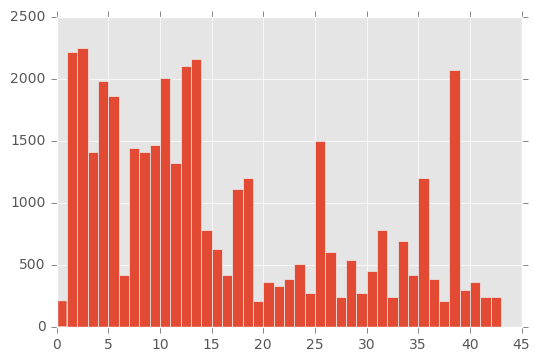

In [30]:
plt.hist(y_train, bins=range(n_classes + 1))

The following snippet shows how we proceeded to extract 20 samples per class:

(array([ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

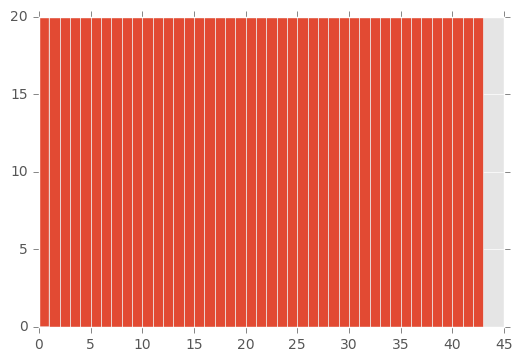

In [31]:
idxs = np.array([], dtype=np.int32)
for i in range(n_classes):
    idxs = np.append(idxs, np.random.choice(np.where(y_train == i)[0], size=20, replace=False))
plt.hist(y_train[idxs], bins=range(n_classes + 1))

Then, we extract the samples from the training set and put them into 2 new variables for validation.

(array([ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

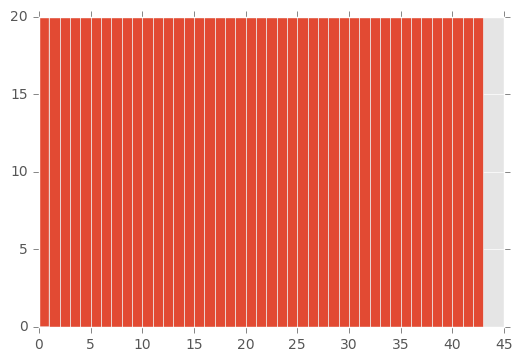

In [32]:
X_validation, y_validation = X_train[idxs], y_train[idxs]
plt.hist(y_validation, bins=range(n_classes + 1))

Finally, we remove these samples from the original training set.

In [33]:
y_train = np.delete(y_train, idxs, 0)
X_train = np.delete(X_train, idxs, 0)

We can see from the histogram below that there are still enough samples left for training which is very important.

(array([  190.,  2200.,  2230.,  1390.,  1960.,  1840.,   400.,  1420.,
         1390.,  1450.,  1990.,  1300.,  2080.,  2140.,   760.,   610.,
          400.,  1090.,  1180.,   190.,   340.,   310.,   370.,   490.,
          250.,  1480.,   580.,   220.,   520.,   250.,   430.,   760.,
          220.,   669.,   400.,  1180.,   370.,   190.,  2050.,   280.,
          340.,   220.,   220.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

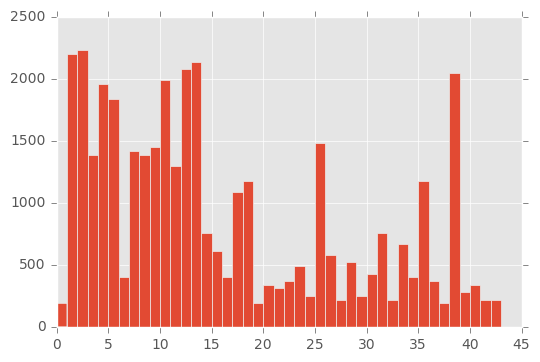

In [34]:
plt.hist(y_train, bins=range(n_classes + 1))

Similarly, our approach for training follows the same principles. One of the biggest challenges we encountered is to make sure all classes were being trained on. Since we picked samples randomely from a balanced class distributions, also known as Stochastic Gradient Descent approach. Originally, the fact that the samples were drawn purely at random presented a problem. At first, the chance of a class which contains about 200 samples were less than 1%. And as we can see in the histogram, there are many such cases. For this reason, we designed balanced approach which gives equal probability for each class to be drawn on each training step.

As we can see in the code snippet below, we first randomly select without replacement 100 samples of each class. And right after, we randomly select without replacement 128 samples for our training batch. This ensures we get equal probability of each class to be represented on each training iteration.

In [35]:
batch_idxs = np.array([], dtype=int32)
for i in range(n_classes):
    batch_idxs = np.append(batch_idxs, np.random.choice(np.where(y_train == i)[0], size=100, replace=False))
idx = np.random.choice(batch_idxs, size=128, replace=False)
idx

array([17610, 33615, 13812, 22940, 27599, 27055, 27505, 31088, 38199,
       18114, 37800, 26191, 14114, 18015, 10245,  8940, 26743, 27583,
       35144, 34339, 26289, 10199, 30127, 34764, 37422,  9981, 12227,
        5055, 26085, 32298, 14345, 26227, 30009, 25651, 32846, 38093,
       19193, 37623, 21609, 21001, 30202, 17236,  9137,  2701, 29881,
       29335, 24673, 22604, 37561,  1826,  4022, 16318, 22365, 30845,
       27912, 37638, 14147,  8328, 38322, 25795, 34684, 35201,    71,
       21331, 14586, 30145, 37366, 27799, 32765, 31055, 29390, 26630,
       22938, 22398,  9975, 27801, 33753, 23679, 31405, 10348, 38143,
       16563,  3253, 11878, 12546, 37811, 34900, 35987,  9526, 33236,
       14844, 12633, 29819, 32688, 17750,  2659, 32658, 37676, 27897,
       38109, 17137, 38182, 34034, 34398, 31408,  3190, 36838, 23442,
       18712,  3791, 24992, 33575, 30233, 16847, 30451, 27496, 13219,
       31104, 23628, 13377, 38272,  3296,  9287,  9610, 32383, 10726,
       16607,  7753]

(array([ 1.,  1.,  7.,  1.,  1.,  6.,  3.,  3.,  4.,  6.,  3.,  7.,  4.,
         3.,  3.,  2.,  3.,  1.,  3.,  2.,  2.,  2.,  1.,  4.,  4.,  2.,
         3.,  4.,  1.,  1.,  5.,  0.,  2.,  4.,  1.,  6.,  3.,  2.,  2.,
         3.,  5.,  2.,  5.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

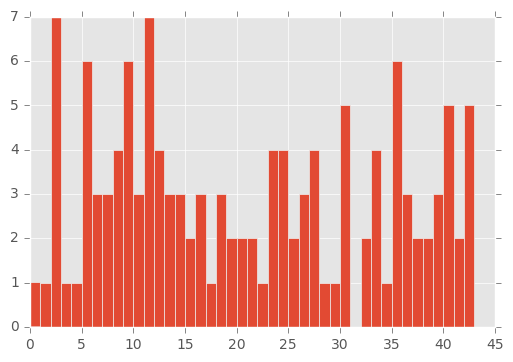

In [36]:
plt.hist(y_train[idx], bins=range(n_classes + 1))

The following figure shows how diverse a subset of the 128 samples looks like. This is a very important step for our solution.

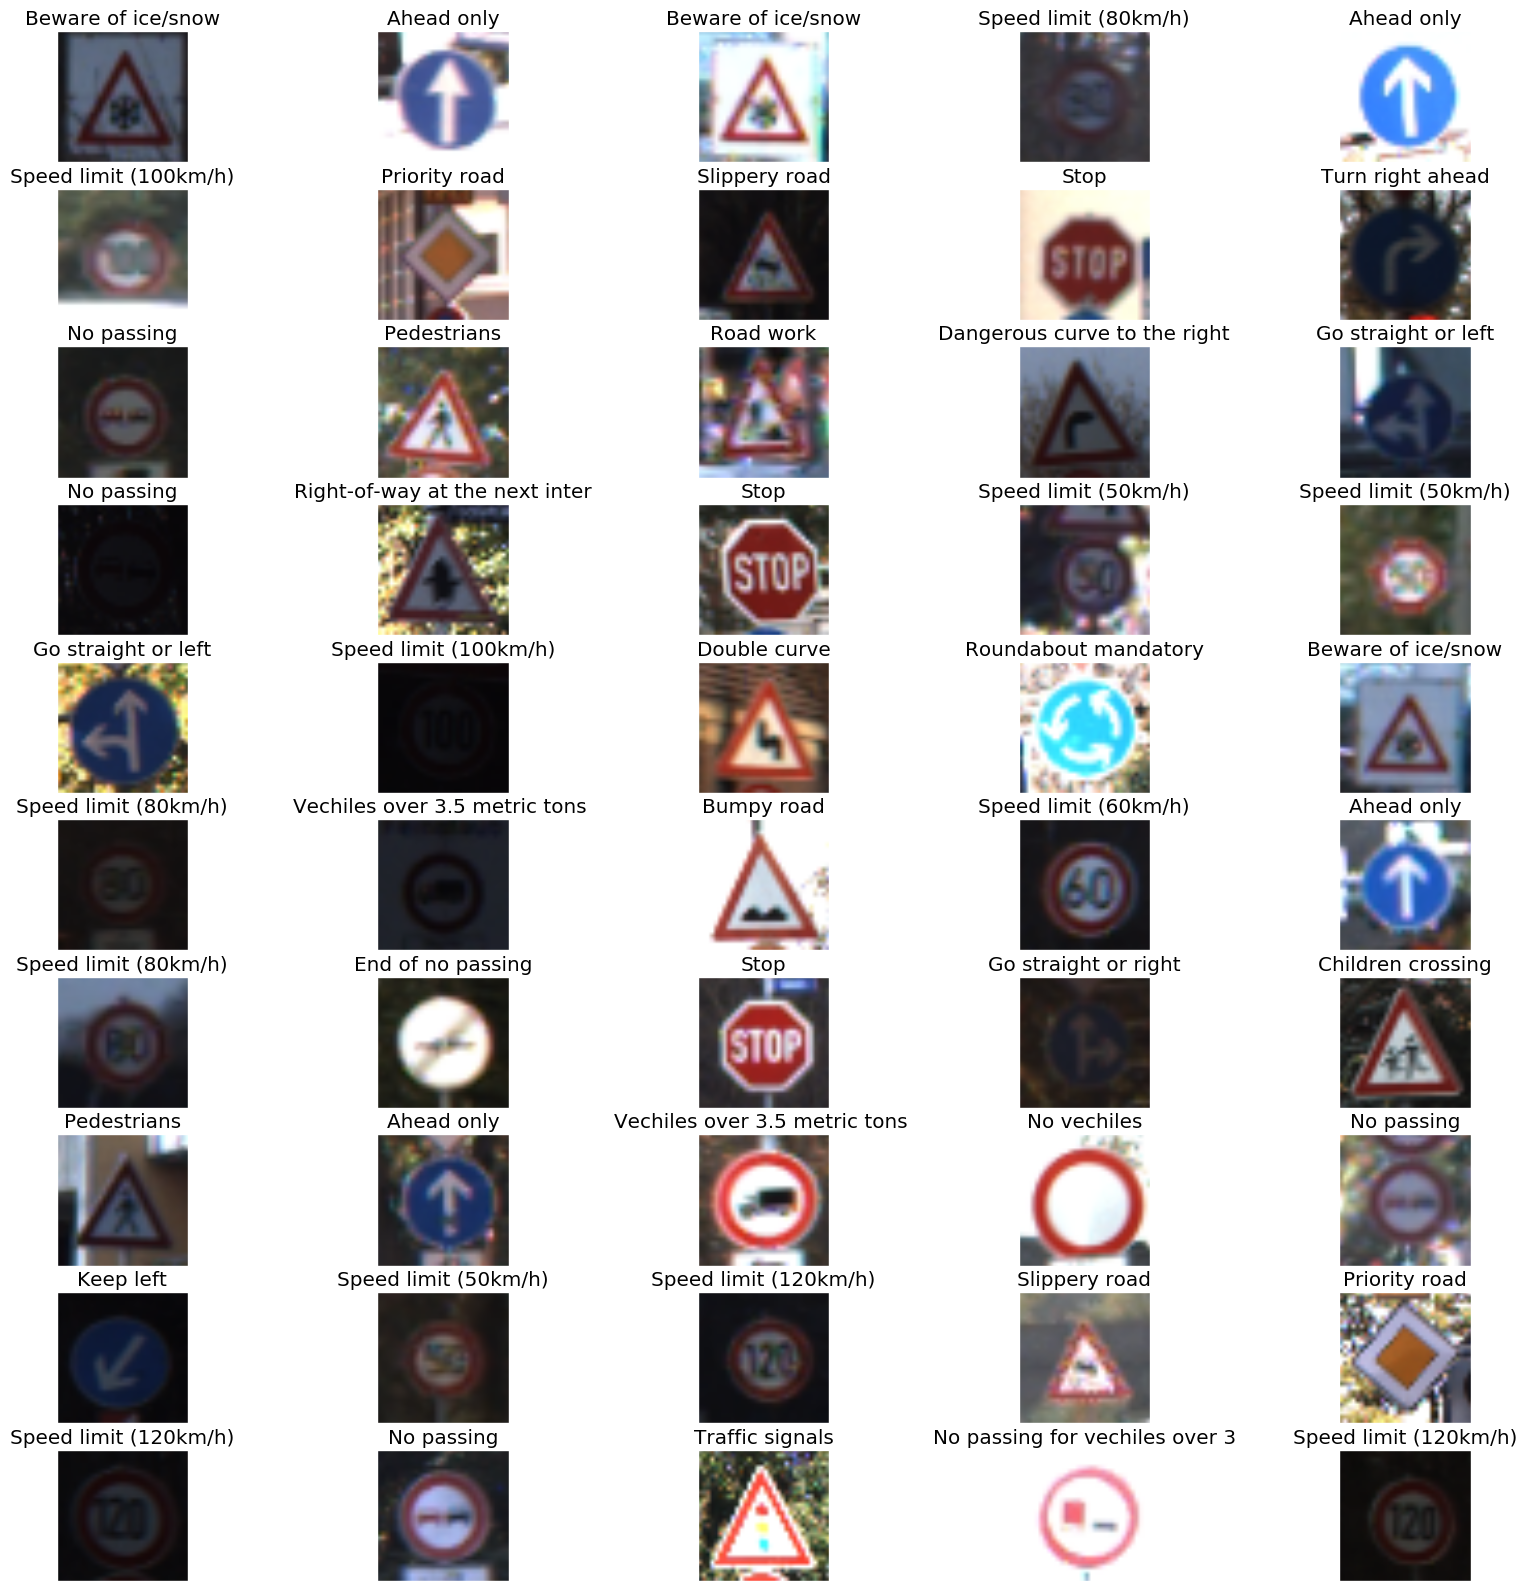

In [37]:
fig = plt.figure(figsize=(20,20))

sidx = np.random.choice(idx, size=50, replace=False)
for i, c in enumerate(sidx):
    ax = fig.add_subplot(10, 5, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.loc[y_train[c],'SignName'][:30])
    ax.imshow(X_train[c])

Having such a well-balance training batch with each iteration means that each training step brings a lot of new information into the model.

Finally, the test set was left intact for the sake of having a good point of comparison. 

(array([  60.,  720.,  750.,  450.,  660.,  630.,  150.,  450.,  450.,
         480.,  660.,  420.,  690.,  720.,  270.,  210.,  150.,  360.,
         390.,   60.,   90.,   90.,  120.,  150.,   90.,  480.,  180.,
          60.,  150.,   90.,  150.,  270.,   60.,  210.,  120.,  390.,
         120.,   60.,  690.,   90.,   90.,   60.,   90.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

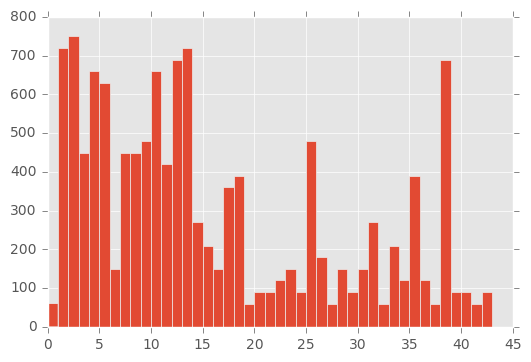

In [38]:
plt.hist(y_test, bins=range(n_classes + 1))

#### Training Step

For our training step we use a regular Gradient Descent Optimizer with the balanced stochastic batch selection mentioned above, an exponential decay learning rate and an exponential moving average. We considered using the Adam Gradient Descent which features some of these same improvements while hiding the complexity of hyper-parameter tuning. However, an Adam optimizer is more compute intensive, and given the short time frame we had to solve this problem the sensible choice was to pick the first option. Given more time, however, it could prove beneficial to use the Adam Optimazer instead.

The total train time varied from 3 hours to over 24 hours on a Titan X (Pascal) GPU. Since the final model didn't use any of the image augmentation methods, the total of 1,000,000 steps took about 4 hours.

<img src="imgs/total_loss.png?dummy=8484744" />
<img src="imgs/cross_entropy.png?dummy=8484744" />
<img src="imgs/learning_rate.png?dummy=8484744" />

From the graph above we can see one of the hyper-parameters, the learning rate and how it decays exponentially as the iterations go on.

We can also observe the cross entropy and total loss which are values we obtain from our optimizer when doing a gradient descent step.

#### Visualizing Conv1 Filters

After fully training the model, we are able to collect the weights on the convolutions and plot them here:

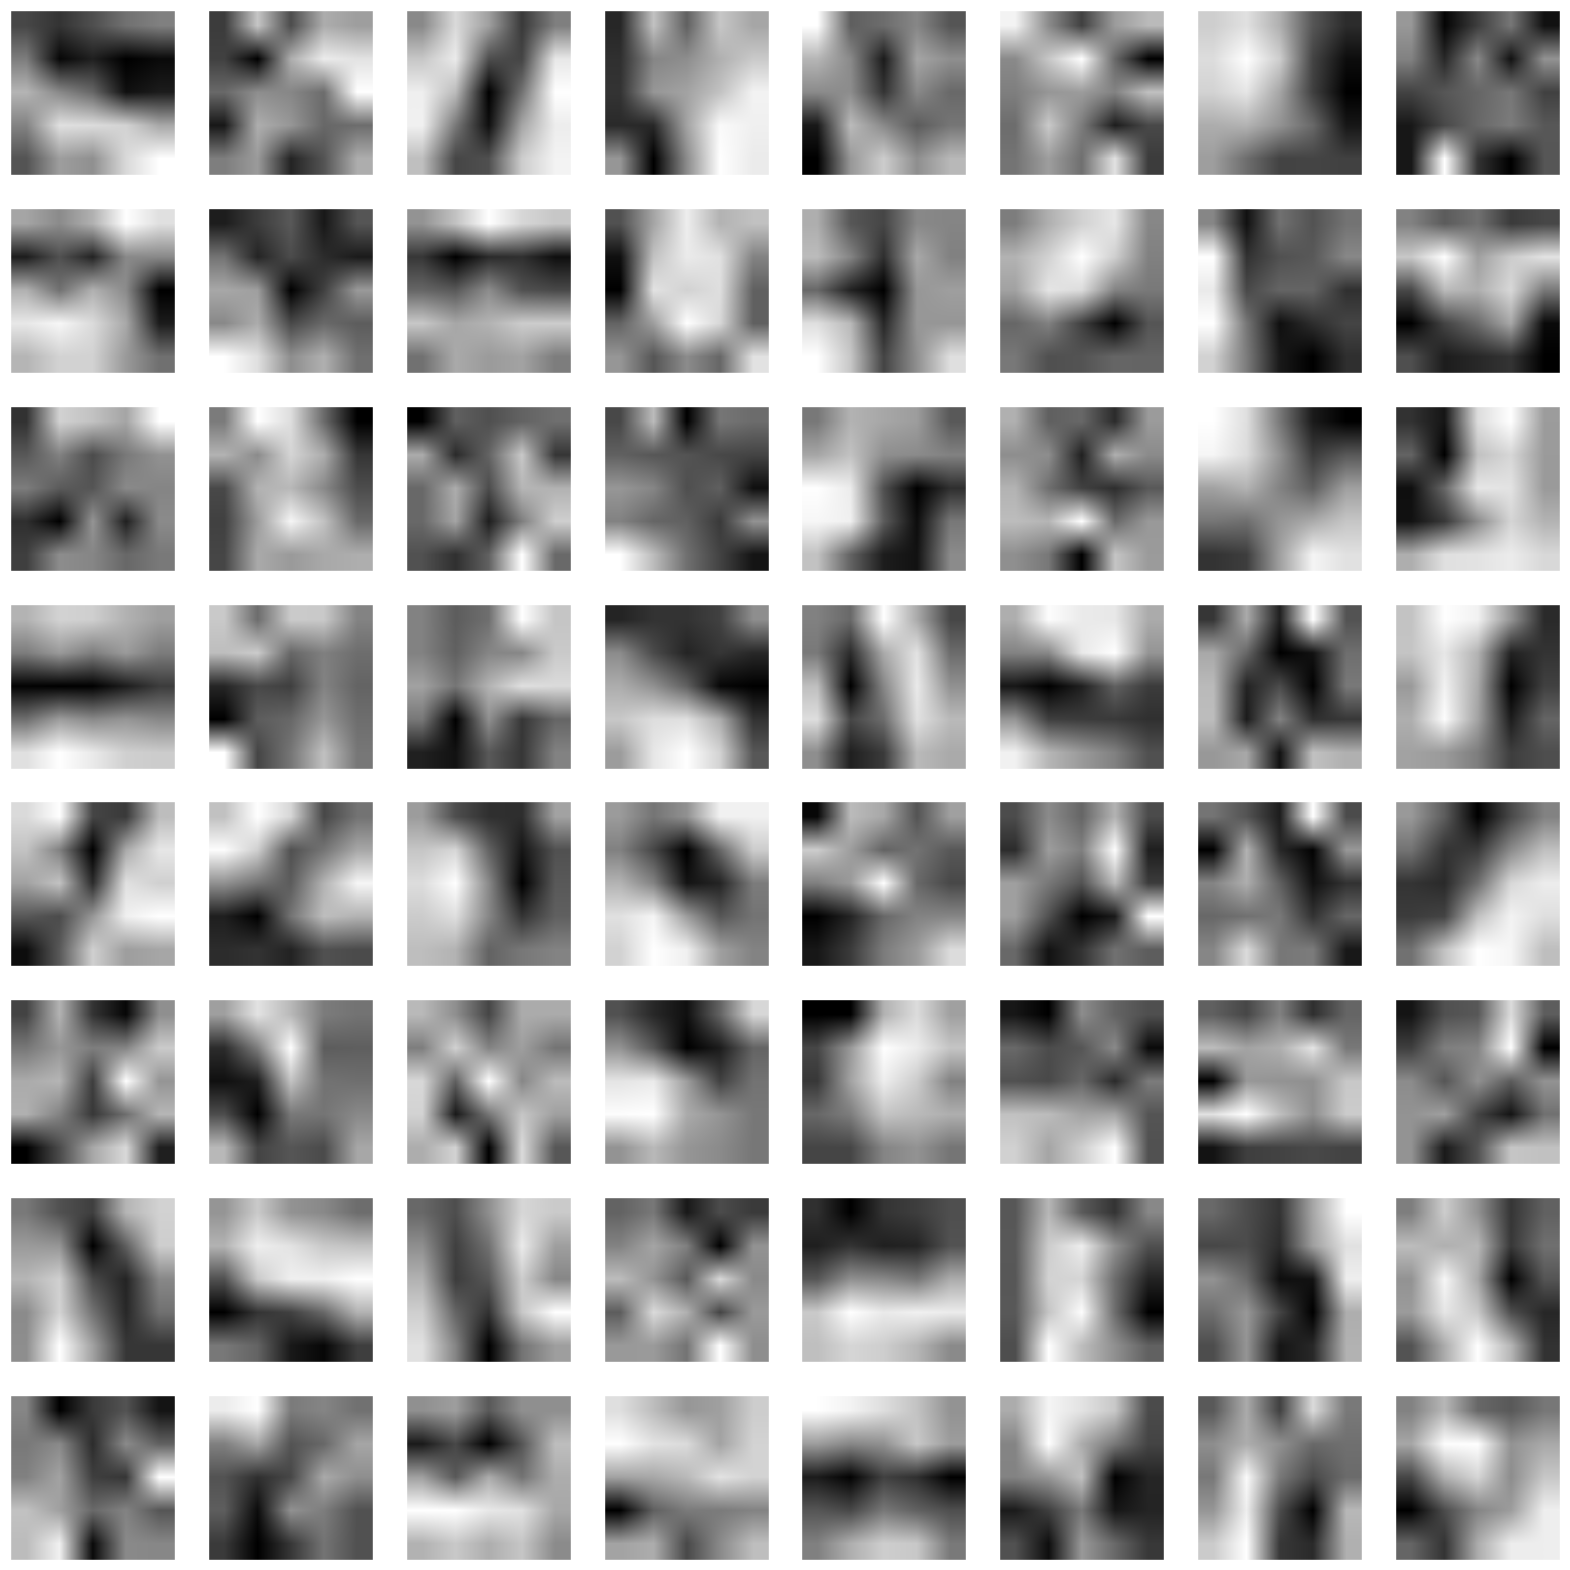

In [39]:
fig = plt.figure(figsize=(20,20))
arr = np.load('checkpoint_dir/conv1_weights_990000.npz')

for filter_ in range(arr.shape[3]):

    # get a single filter
    extracted_filter = arr[:, :, :, filter_]
    
    # merge the channels
    extracted_filter = np.mean(extracted_filter, axis=2)
    
    # display the filter
    ax = fig.add_subplot(8, 8, filter_ + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(extracted_filter, cmap='gray')

#### Visualizing Conv2 Filters

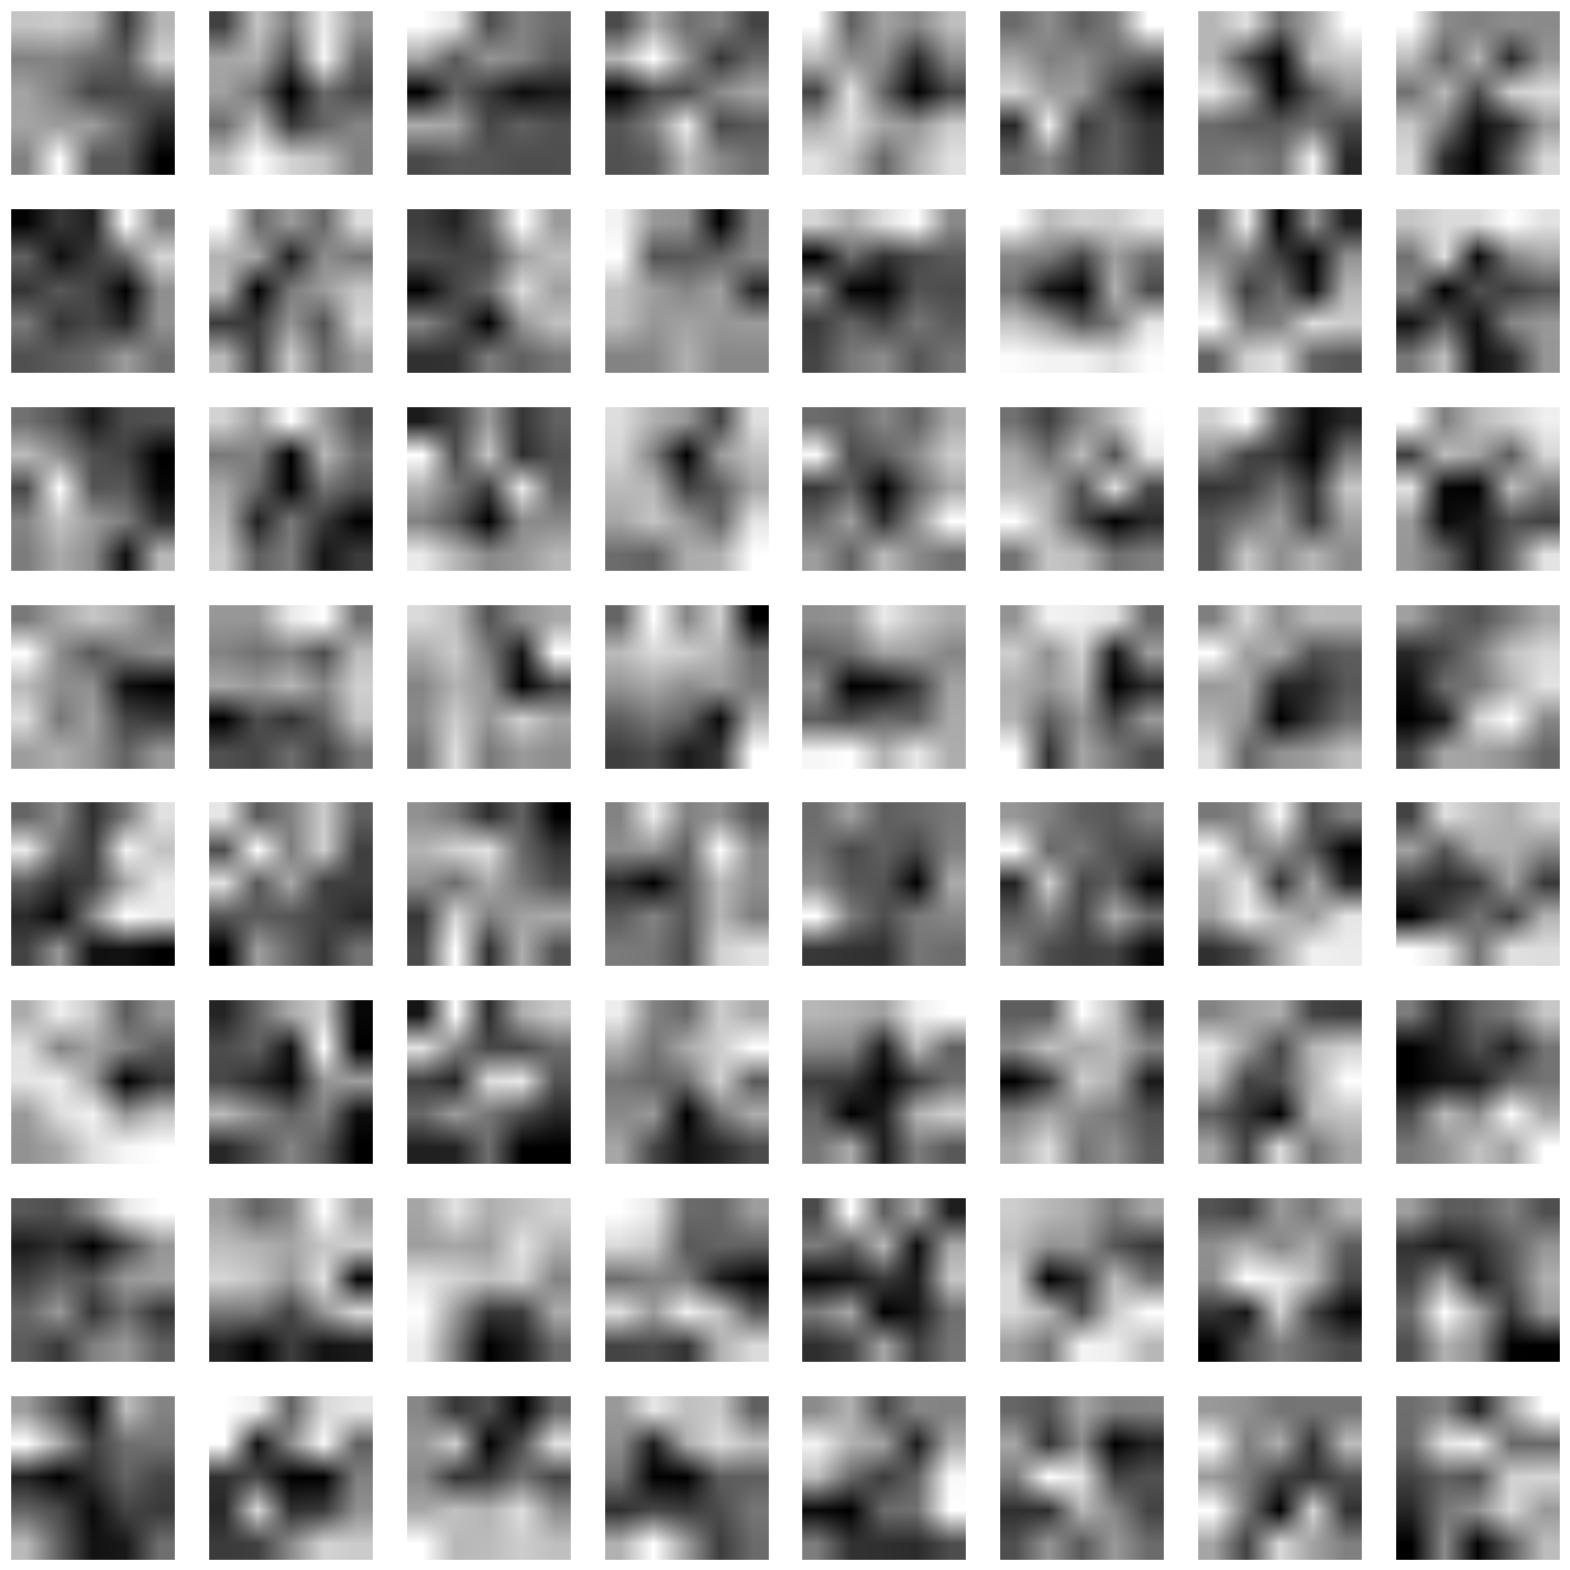

In [40]:
fig = plt.figure(figsize=(20,20))
arr = np.load('checkpoint_dir/conv2_weights_990000.npz')

for filter_ in range(arr.shape[3]):

    # get a single filter
    extracted_filter = arr[:, :, :, filter_]
    
    # merge the channels
    extracted_filter = np.mean(extracted_filter, axis=2)
    
    # display the filter
    ax = fig.add_subplot(8, 8, filter_ + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(extracted_filter, cmap='gray')

We can see how the first convolution have more basic shapes like vertical, horizontal and diagonal lines while the second convolution have a combination of these first convolution. These are the parts that compose the features for the classifier. 

### Model Evaluation

Our model evaluation is composed of several metrics. We calculated the accuracy, weighted precision, weighted recall, weighted f1 score and cohen kappa score of the batches, training, validation and test set every so often.

Let's first add some helper functions that will allow us to do our evaluations.

#### Helper Functions

In [41]:
def eval_img(saver, logits, img, label, 
             images_p, labels_p, keep_prob_p):
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state('checkpoint_dir')
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        else:
            return
        sign_strings = pd.read_csv('signnames.csv', index_col=0)
        slabel = label if label else [0]
        probs = sess.run(logits, feed_dict={images_p:img, 
                                            labels_p:slabel, 
                                            keep_prob_p:1.0})[0]
        sign_strings['prob'] = pd.Series(probs, index=sign_strings.index)
        if label:
            sign_strings['correct'] = pd.Series(sign_strings.index.values == label, index=sign_strings.index)
        return sign_strings.sort_values(['prob', 'SignName'], ascending=[0, 1])


def eval_once(saver, top_k_op, X_test, y_test, 
              images_p, labels_p, keep_prob_p):
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state('checkpoint_dir')
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        else:
            print('No checkpoint file found')
            return

        predictions = sess.run(top_k_op, feed_dict={images_p:X_test, 
                                                    labels_p:y_test, 
                                                    keep_prob_p:1.0})
        true_count = np.sum(predictions)
        precision = true_count / len(X_test)
    return precision

def get_precision(k = 1):
    with tf.Graph().as_default() as g:
        images_p = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        labels_p = tf.placeholder(tf.int32, shape=[None])
        keep_prob_p = tf.placeholder(tf.float32)

        # Augment images batch
        # process_op = augment_images(images_p)

        # Calculate the logits and loss
        pool2 = convolutions(images_p)
        logits = fully_connected_nn(pool2, keep_prob=keep_prob_p)

        # Calculate predictions.
        top_k_op = tf.nn.in_top_k(logits, labels_p, k)

        # Restore the moving average version of the learned variables for eval.
        variable_averages = tf.train.ExponentialMovingAverage(
            classifier.MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)    
        precision = eval_once(saver, top_k_op, X_test, y_test, 
                              images_p, labels_p, keep_prob_p)
        print('%s: Test Set Top %s Precision %.3f' % (datetime.datetime.now(), k, precision))
        

def get_top_matches(image, label = None):
    with tf.Graph().as_default() as g:
        images_p = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        labels_p = tf.placeholder(tf.int32, shape=[None])
        keep_prob_p = tf.placeholder(tf.float32)

        # process_op = augment_images(images_p)

        pool2 = convolutions(images_p)
        logits = fully_connected_nn(pool2, keep_prob=keep_prob_p)
        
        # Restore the moving average version of the learned variables for eval.
        variable_averages = tf.train.ExponentialMovingAverage(
            classifier.MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)  
        predictions = eval_img(saver, logits,
                               image, label,
                               images_p, labels_p, keep_prob_p)
        return predictions
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, around(cm[i, j], decimals=2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Evaluation Metrics

We calculated the accuracy, weighted precision, weighted recall, weighted f1 score and cohen kappa.

The accuracy is the set of labels predicted for a sample that exactly match the corresponding set of true labels. 0 being the lowest, 1 greatest. Precision is the ability of the classifier not to misclassify a given sample. 0 being the lowest, 1 greatest. Recall is the ability of the classifier to find correctly classify a given samples. 0 being the lowest, 1 greatest. F1 Score is a relative contribution of each sample given it's precision and recall. 0 being the lowest, 1 greatest. The Cohen-Kappa metric compares the accuracy with an accuracy given by random chance. Values of 0.60 are considered good with 0.80 or more being almost perfect.

#### Results

The following are the results for all the metrics on the each of the batches the model was trained on:

<img src="imgs/batch_accuracy.png?dummy=8484744" />
<img src="imgs/batch_precision.png?dummy=8484744" />
<img src="imgs/batch_recall.png?dummy=8484744" />
<img src="imgs/batch_f1.png?dummy=8484744" />
<img src="imgs/batch_cohen_kappa.png?dummy=8484744" />

Next, we show the results for all the metrics on 10,000 samples training set sampled every 10,000 iterations:

<img src="imgs/train_accuracy.png?dummy=8484744" />
<img src="imgs/train_precision.png?dummy=8484744" />
<img src="imgs/train_recall.png?dummy=8484744" />
<img src="imgs/train_f1.png?dummy=8484744" />
<img src="imgs/train_cohen_kappa.png?dummy=8484744" />

Now, the same but with the validation se which was a very smalled select set with less than 1,000 samples and perfectly balanced on the classes:

<img src="imgs/validation_accuracy.png?dummy=8484744" />
<img src="imgs/validation_precision.png?dummy=8484744" />
<img src="imgs/validation_recall.png?dummy=8484744" />
<img src="imgs/validation_f1.png?dummy=8484744" />
<img src="imgs/validation_cohen_kappa.png?dummy=8484744" />

Finally, the most important set of all, the test set:

<img src="imgs/test_accuracy.png?dummy=8484744" />
<img src="imgs/test_precision.png?dummy=8484744" />
<img src="imgs/test_recall.png?dummy=8484744" />
<img src="imgs/test_f1.png?dummy=8484744" />
<img src="imgs/test_cohen_kappa.png?dummy=8484744" />

As we can see from the graphs above, the model was actually almost fully trained by 200,000 iterations. Interestingly, some of the later bumps were related to the exponential learning rate decaying and further enabling for more fine-grained learning.

#### Raw Accuracy

First, let's look at what is arguably the most important statistic, the model's raw accuracy.

In [42]:
get_precision(k=1)

2016-11-27 18:49:07.329200: Test Set Top 1 Precision 0.932


This is actually a pretty solid accuracy. Even though the human performace was at about 98.81%, over 93% is a fairly good result.

#### Top 5 Accuracy

However, if we take into account the top 5 picks, our models does much better.

In [43]:
get_precision(k=5)

2016-11-27 18:49:25.283413: Test Set Top 5 Precision 0.945


There is definitely room for improvement, but ~95% is a solid result.

#### Confusion Matrix

Let's now look into a confusion matrix of the final model in order to better understand where our model made its mistakes.

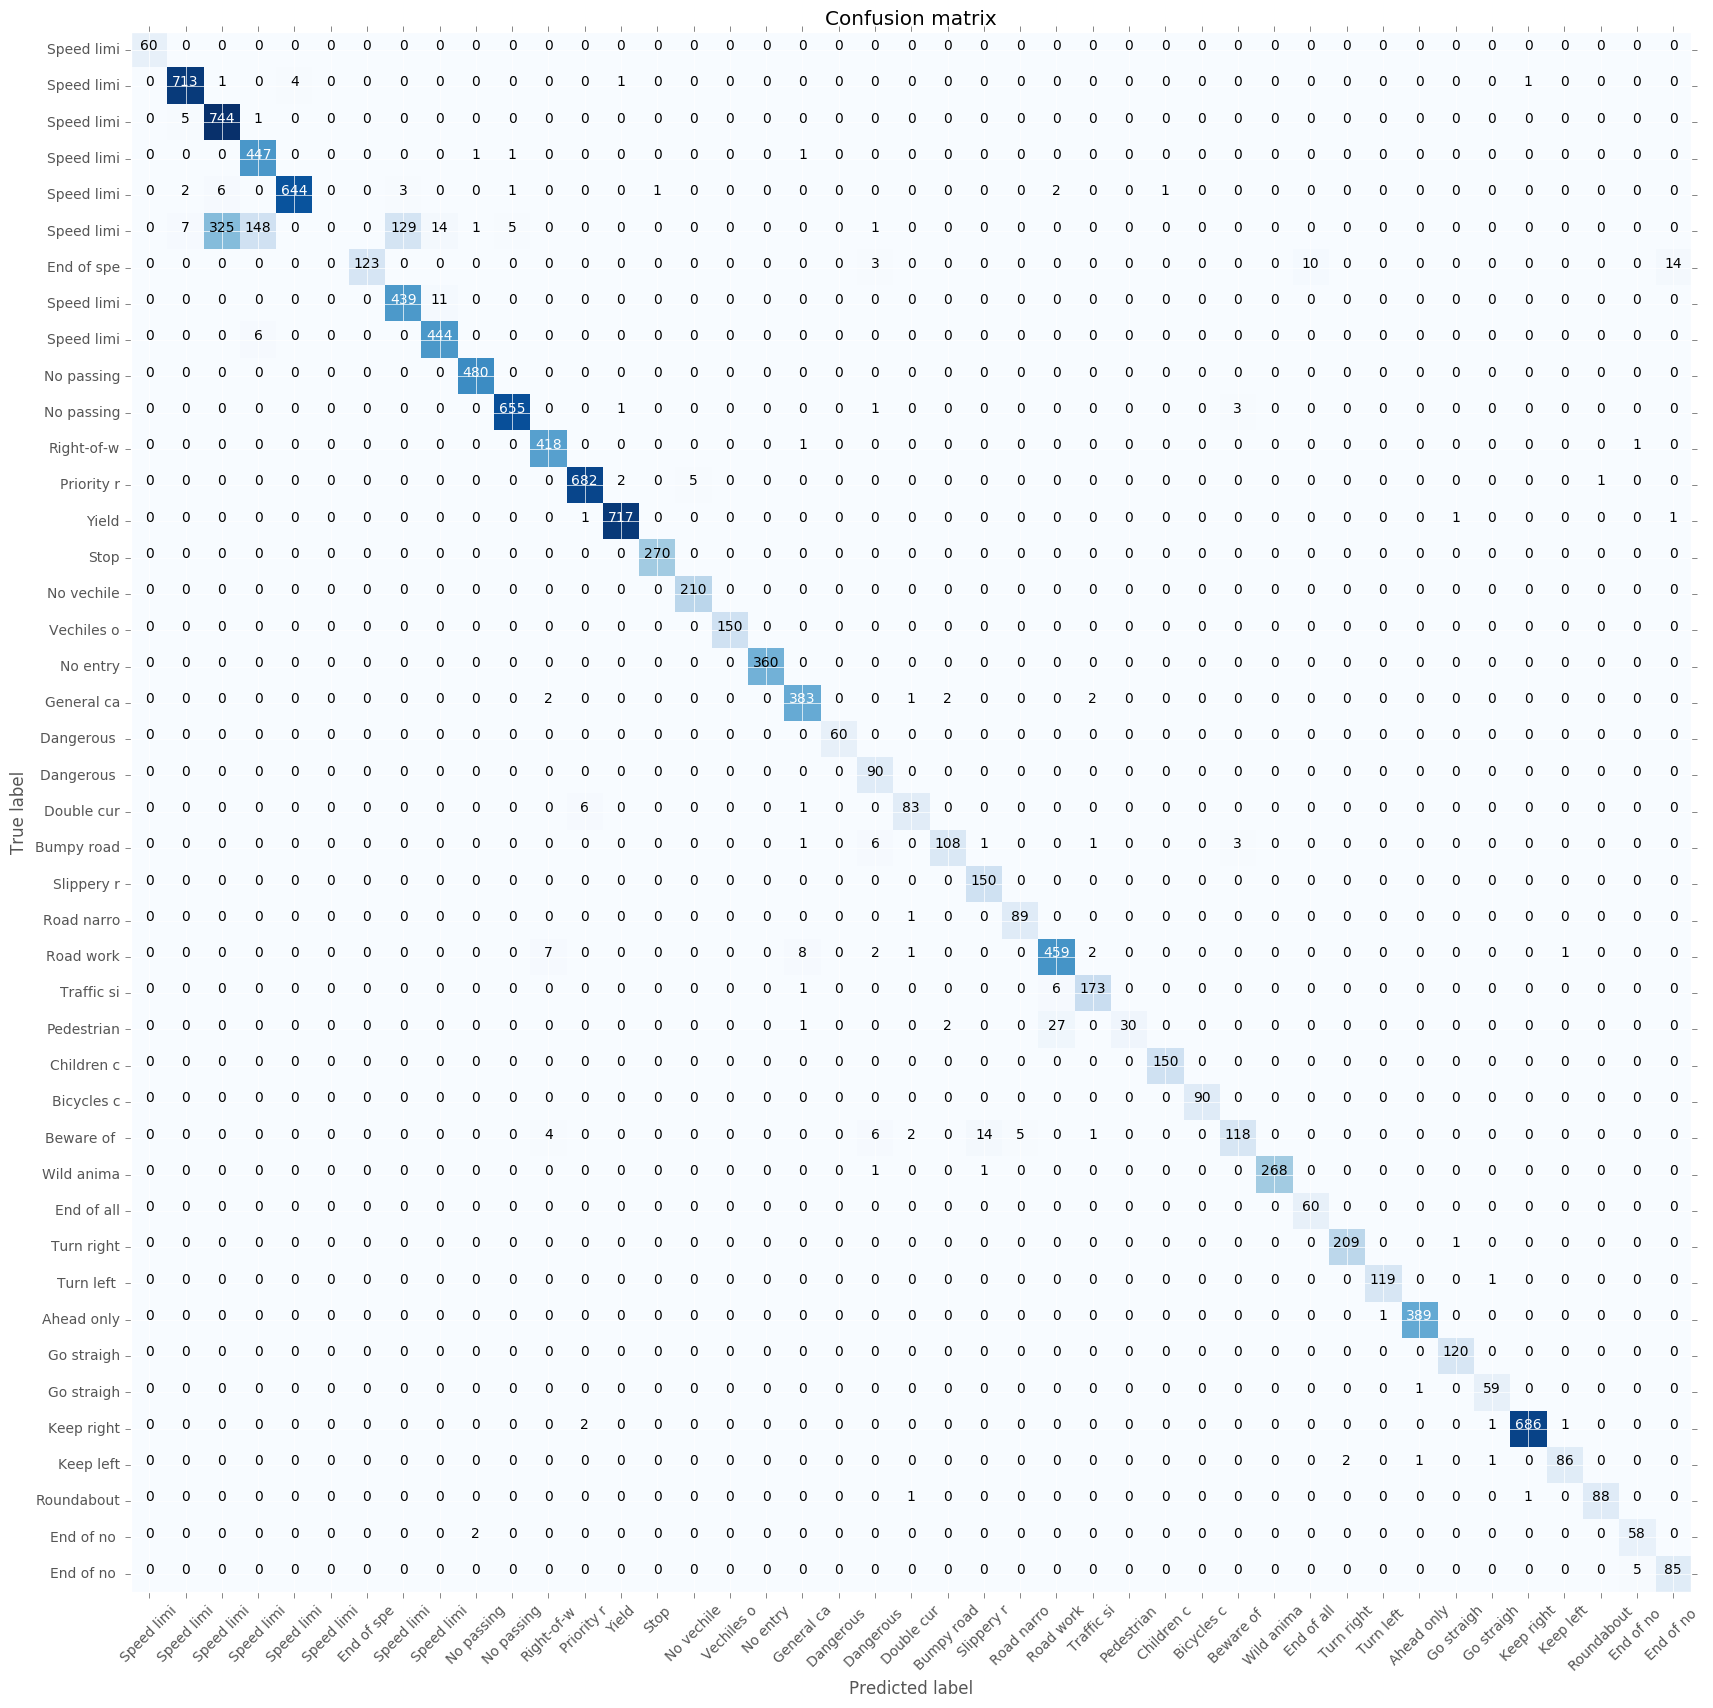

In [44]:
cnf_matrix = np.load('checkpoint_dir/conv2_cmatrix_990000.npz')
# Plot normalized confusion matrix
plt.figure(figsize=(17,17))
plot_confusion_matrix(cnf_matrix, classes=[t[:10] for t in sign_strings['SignName']])

We can see how only a few classes are flat out wrong and present a problem. It seems the sixth is such a class, let's see which on is that.

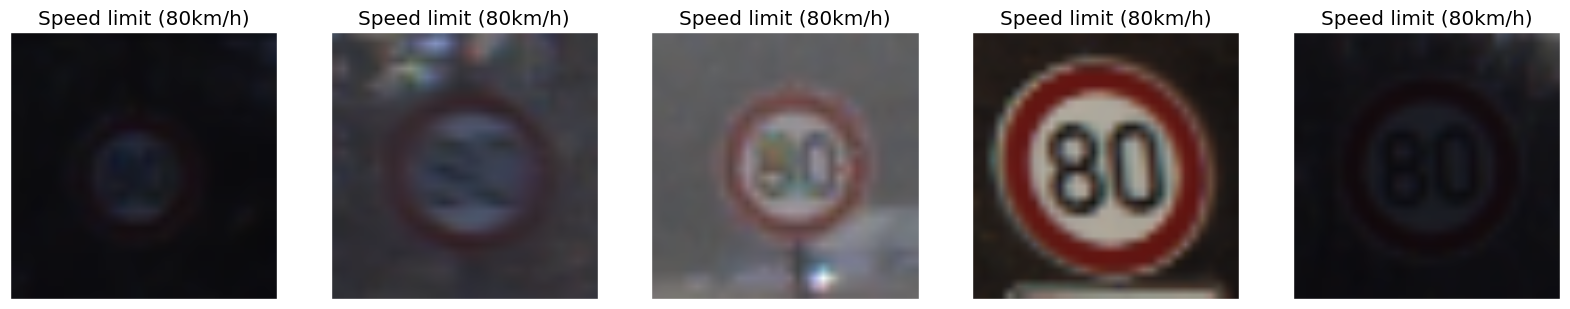

In [45]:
fig = plt.figure(figsize=(20,20))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.iloc[5]['SignName'][:30])
    ax.imshow(X_train[np.random.choice(np.where(y_train == 5)[0])])

And these are the conflicting classes: 

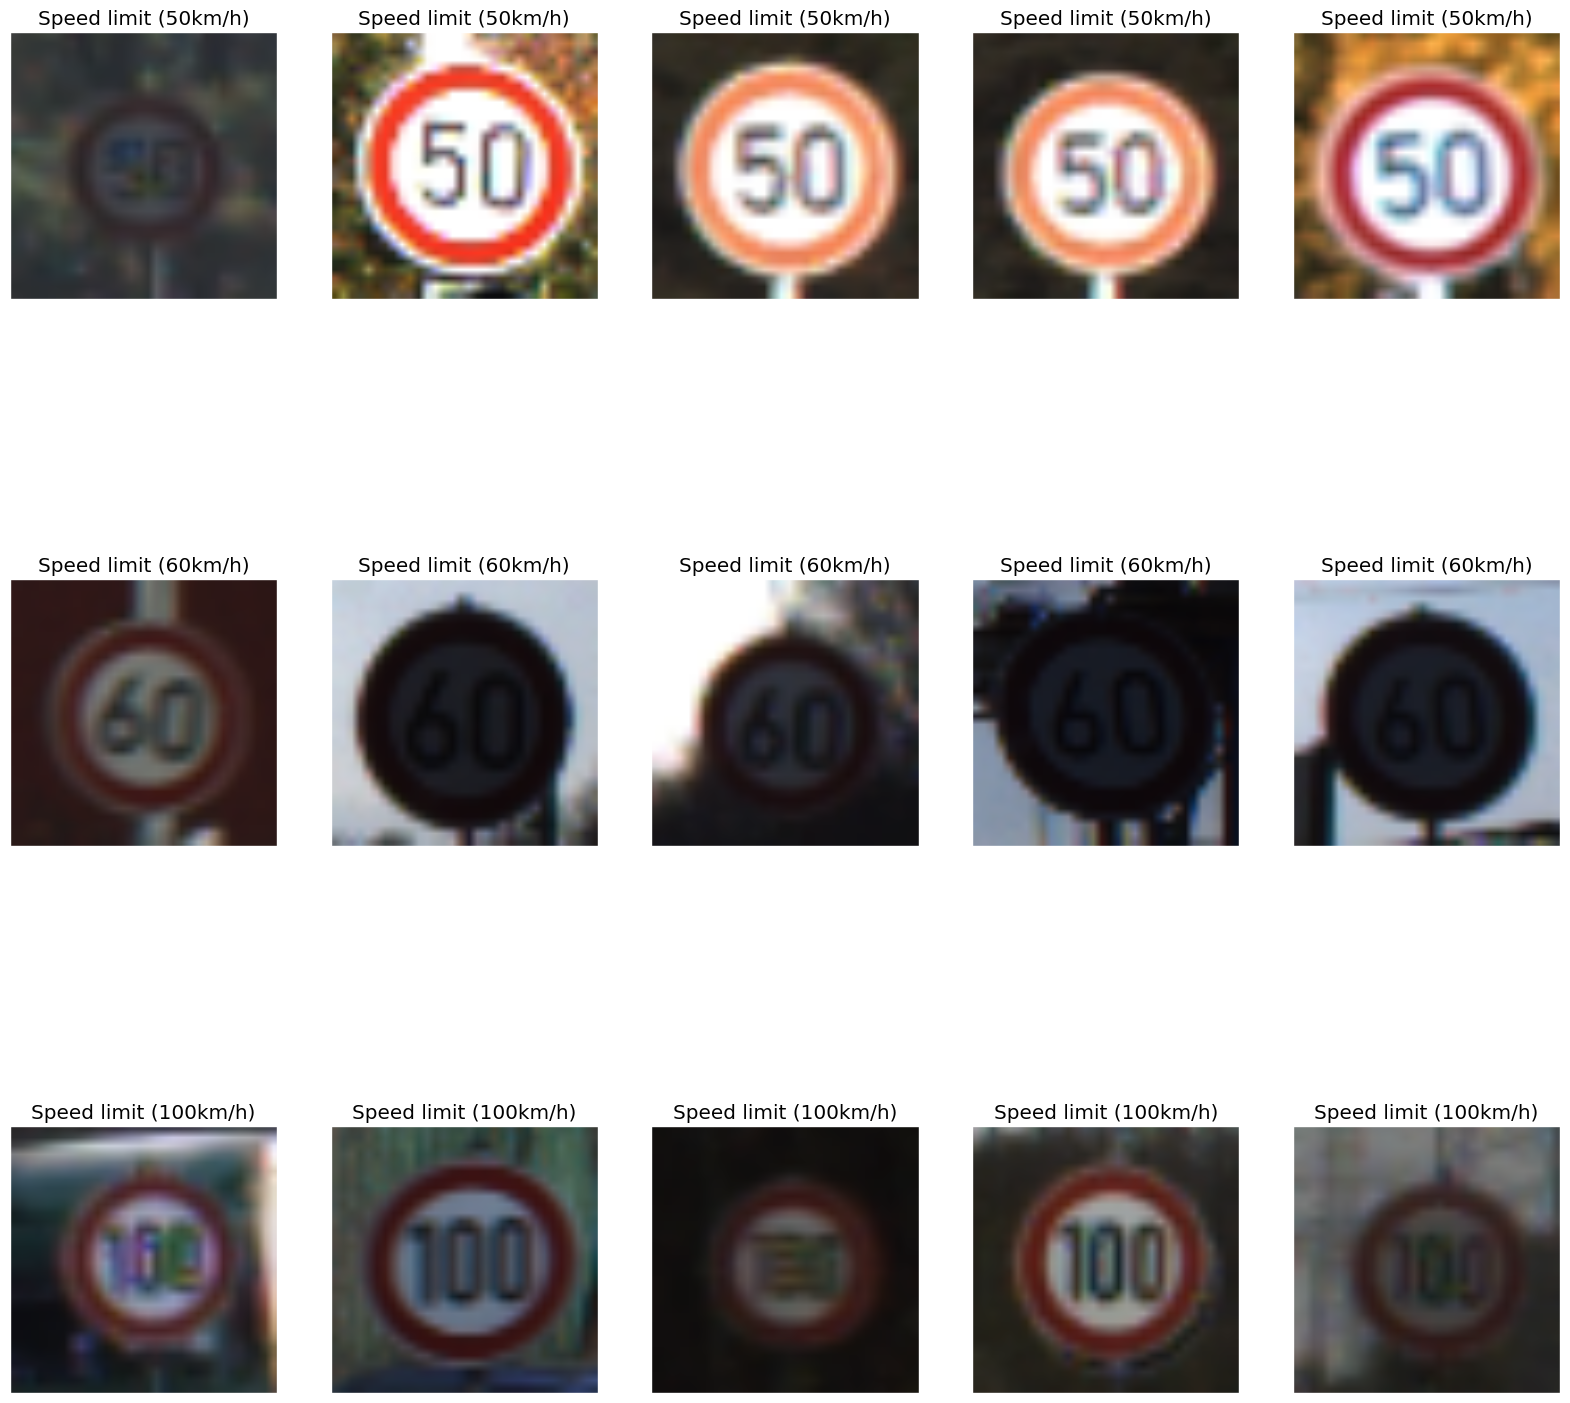

In [46]:
fig = plt.figure(figsize=(20,20))
for i in range(5):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.iloc[2]['SignName'][:30])
    ax.imshow(X_train[np.random.choice(np.where(y_train == 2)[0])])

for i in range(5):
    ax = fig.add_subplot(3, 5, i + 6)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.iloc[3]['SignName'][:30])
    ax.imshow(X_train[np.random.choice(np.where(y_train == 3)[0])])

for i in range(5):
    ax = fig.add_subplot(3, 5, i + 11)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.iloc[7]['SignName'][:30])
    ax.imshow(X_train[np.random.choice(np.where(y_train == 7)[0])])

Fair enough, the main issue seems to be with the speed limits. Perhaps, a change in the way we do convolutions would greatly improve the accuracy of the model since the main difference in the pictures is concentrated into the detail of the numbers. Adding convolutions with larger window strides could be helpful. This is something definitely to try for next iterations of this solution.

#### Classification Report

Another interesting statistic that could help us identify problematic classes is the classification report. This was calculated on the test set while training every 10,000th iteration. The following is such report.

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      1.00      1.00        60
                              Speed limit (30km/h)       0.98      0.99      0.99       720
                              Speed limit (50km/h)       0.69      0.99      0.81       750
                              Speed limit (60km/h)       0.74      0.99      0.85       450
                              Speed limit (70km/h)       0.99      0.98      0.98       660
                              Speed limit (80km/h)       0.00      0.00      0.00       630
                       End of speed limit (80km/h)       1.00      0.82      0.90       150
                             Speed limit (100km/h)       0.77      0.98      0.86       450
                             Speed limit (120km/h)       0.95      0.99      0.97       450
                                        No passing       0.99      1.00      1.00       480
      No passing for vechiles over 3.5 metric tons       0.99      0.99      0.99       660
             Right-of-way at the next intersection       0.97      1.00      0.98       420
                                     Priority road       0.99      0.99      0.99       690
                                             Yield       0.99      1.00      1.00       720
                                              Stop       1.00      1.00      1.00       270
                                       No vechiles       0.98      1.00      0.99       210
          Vechiles over 3.5 metric tons prohibited       1.00      1.00      1.00       150
                                          No entry       1.00      1.00      1.00       360
                                   General caution       0.96      0.98      0.97       390
                       Dangerous curve to the left       1.00      1.00      1.00        60
                      Dangerous curve to the right       0.82      1.00      0.90        90
                                      Double curve       0.93      0.92      0.93        90
                                        Bumpy road       0.96      0.90      0.93       120
                                     Slippery road       0.90      1.00      0.95       150
                         Road narrows on the right       0.95      0.99      0.97        90
                                         Road work       0.93      0.96      0.94       480
                                   Traffic signals       0.97      0.96      0.96       180
                                       Pedestrians       1.00      0.50      0.67        60
                                 Children crossing       0.99      1.00      1.00       150
                                 Bicycles crossing       1.00      1.00      1.00        90
                                Beware of ice/snow       0.95      0.79      0.86       150
                             Wild animals crossing       1.00      0.99      1.00       270
               End of all speed and passing limits       0.86      1.00      0.92        60
                                  Turn right ahead       0.99      1.00      0.99       210
                                   Turn left ahead       0.99      0.99      0.99       120
                                        Ahead only       0.99      1.00      1.00       390
                              Go straight or right       0.98      1.00      0.99       120
                               Go straight or left       0.95      0.98      0.97        60
                                        Keep right       1.00      0.99      1.00       690
                                         Keep left       0.98      0.96      0.97        90
                              Roundabout mandatory       0.99      0.98      0.98        90
                                 End of no passing       0.91      0.97      0.94        60
End of no passing by vechiles over 3.5 metric tons       0.85      0.94      0.89        90

                                       avg / total       0.90      0.93      0.91     12630


From this we can see that it is of absolute importance to further improve the network to something like the inception CNN which adds up features from different convolutions this way maintaining both important features that are high level and low level.

#### Single Image Samples

Let's look at specific randomly picked examples and detailed predictions.

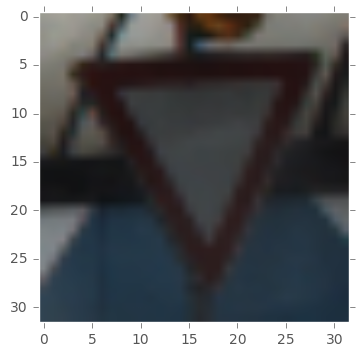

In [47]:
idx = np.random.randint(len(X_train))
img = X_train[idx]
label = y_train[idx]
plt.grid(False)
plt.imshow(img)

In [48]:
matches = get_top_matches([img], [label])
matches.head()

SignName          prob correct
ClassId                                                           
13                                     Yield  1.000000e+00    True
35                                Ahead only  5.712942e-09   False
12                             Priority road  4.452139e-09   False
9                                 No passing  2.974794e-09   False
32       End of all speed and passing limits  1.435781e-09   False

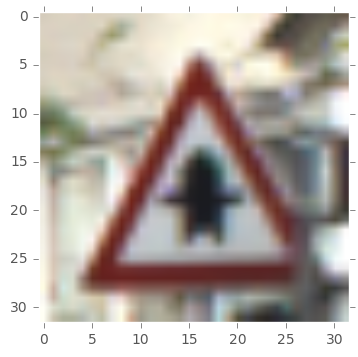

In [49]:
idx = np.random.randint(len(X_train))
img = X_train[idx]
label = y_train[idx]
plt.grid(False)
plt.imshow(img)

In [50]:
matches = get_top_matches([img], [label])
matches.head()

SignName          prob correct
ClassId                                                             
11       Right-of-way at the next intersection  9.999981e-01    True
18                             General caution  1.042299e-06   False
21                                Double curve  6.786144e-07   False
30                          Beware of ice/snow  1.115604e-07   False
7                        Speed limit (100km/h)  3.286794e-08   False

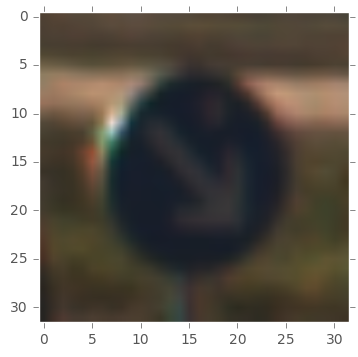

In [51]:
idx = np.random.randint(len(X_train))
img = X_train[idx]
label = y_train[idx]
plt.grid(False)
plt.imshow(img)

In [52]:
matches = get_top_matches([img], [label])
matches.head()

SignName          prob correct
ClassId                                            
38                 Keep right  9.999982e-01    True
34            Turn left ahead  4.340400e-07   False
2        Speed limit (50km/h)  4.218180e-07   False
12              Priority road  2.781861e-07   False
36       Go straight or right  1.354568e-07   False

Great results!

#### Localized Images Results

We also tested our model against a few images that do not belong to the original data set, but collected online instead. Let's take a look at the images.

In [53]:
localized_paths = ['imgs/local1.jpg', 'imgs/local2.jpg', 
                   'imgs/local3.jpg', 'imgs/local4.jpg',
                   'imgs/local5.jpg', 'imgs/local6.jpg',
                   'imgs/local7.jpg', 'imgs/local8.jpg',
                   'imgs/local9.jpeg', 'imgs/local10.jpg']
localized_imgs = np.array([misc.imresize(misc.imread(p), (32,32)) for p in localized_paths])

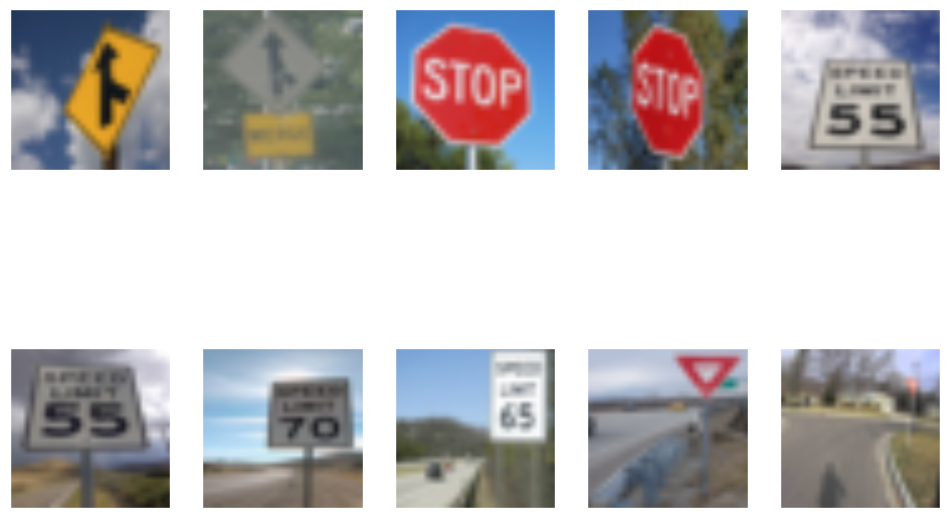

In [54]:
fig = plt.figure(figsize=(12,8))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(localized_imgs[i])

It's important to note that none of these images belong to the data set. Also, they have all been resized and therefore have a rather distorted resolution. Finally, even though signs like "Stop" are universal, for some of these US signs there are no exact classes (not to mention the KM vs Miles issue!). 

Let's see how well our model does when tested on these images.

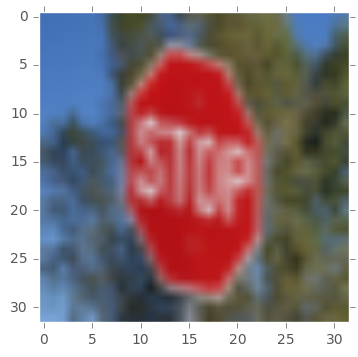

In [55]:
idx = np.random.randint(len(localized_imgs))
img = localized_imgs[idx]
label = localized_imgs[idx]
plt.grid(False)
plt.imshow(img)

In [56]:
matches = get_top_matches([img])
matches.head()

SignName      prob
ClassId                           
14                  Stop  0.991436
17              No entry  0.008070
13                 Yield  0.000278
12         Priority road  0.000126
18       General caution  0.000021

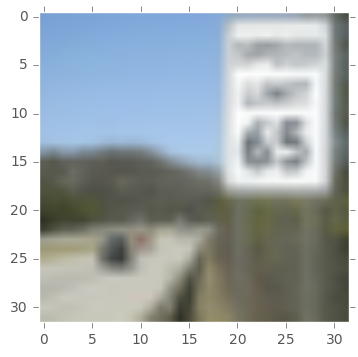

In [57]:
idx = np.random.randint(len(localized_imgs))
img = localized_imgs[idx]
label = localized_imgs[idx]
plt.grid(False)
plt.imshow(img)

In [58]:
matches = get_top_matches([img])
matches.head()

SignName      prob
ClassId                                                             
42       End of no passing by vechiles over 3.5 metric ...  0.363814
13                                                   Yield  0.239710
12                                           Priority road  0.113348
36                                    Go straight or right  0.069701
40                                    Roundabout mandatory  0.047381

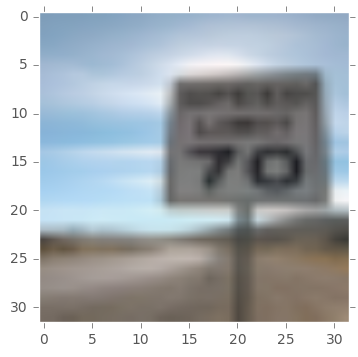

In [59]:
idx = np.random.randint(len(localized_imgs))
img = localized_imgs[idx]
label = localized_imgs[idx]
plt.grid(False)
plt.imshow(img)

In [60]:
matches = get_top_matches([img])
matches.head()

SignName      prob
ClassId                                                 
1                         Speed limit (30km/h)  0.794427
6                  End of speed limit (80km/h)  0.100179
11       Right-of-way at the next intersection  0.021483
18                             General caution  0.018549
38                                  Keep right  0.015831

Not to be impressed with, but at least it got the stop sign right which was expected.

#### Video Stream Results

Finally, we test our model on a video feed. This is a much more challenging task because the model was trained on cropped images, therefore it lacks a detection mechanism.

Traditionally, this problem would be separated into Traffic Sign Detection (TSD) and Traffic Sign Classification (TSC). This project concentrates on TSC because the job of detecting the sign on an image had already been pre-processed on the data. The images came in already cropped centered on the traffic sign. Regardless, this is how the model did on a couple of videos taken by myself for the purpose of this project.

Let's add the helper functions and process each video.

#### Helper Functions

In [61]:
def process_image(img, **kwargs):
    """
    Lane Line Detection processing pipeline.
    """
    matches = get_top_matches([misc.imresize(img, (32,32))])
   
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, row in enumerate(matches.head().iterrows()):
        classId = row[0]
        name = row[1]['SignName'][:20]
        value = row[1]['prob']*100
        cv2.putText(img, name,
                    (50,50*(i+1)), font, 1,(255,255,255),2)
        cv2.putText(img, "{:10.2f}".format(value),
                    (350,50*(i+1)), font, 1,(255,255,255),2)
    
    top_pred_class = matches.index[0]
    top_pred_img = misc.imresize(X_train[
            np.random.choice(np.where(y_train == top_pred_class)[0])], (300,300))
    x_offset=img.shape[1]-top_pred_img.shape[1]-10
    y_offset=10
    img[y_offset:y_offset+top_pred_img.shape[0], 
        x_offset:x_offset+top_pred_img.shape[1]] = top_pred_img
    
    return img

In [62]:
clip1 = VideoFileClip("videos/VID_20161126_130029.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile("videos/out1.mp4", audio=False)

[MoviePy] >>>> Building video videos/out1.mp4
[MoviePy] Writing video videos/out1.mp4


100%|██████████| 704/704 [02:05<00:00,  5.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/out1.mp4 

CPU times: user 2min 2s, sys: 2.63 s, total: 2min 5s
Wall time: 2min 6s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("videos/out1.mp4"))

In [64]:
clip1 = VideoFileClip("videos/VID_20161126_130348.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile("videos/out2.mp4", audio=False)

[MoviePy] >>>> Building video videos/out2.mp4
[MoviePy] Writing video videos/out2.mp4


100%|██████████| 342/342 [00:58<00:00,  6.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/out2.mp4 

CPU times: user 57.8 s, sys: 1.41 s, total: 59.2 s
Wall time: 59.4 s


In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("videos/out2.mp4"))

In [66]:
clip1 = VideoFileClip("videos/VID_20161126_130457.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile("videos/out3.mp4", audio=False)

[MoviePy] >>>> Building video videos/out3.mp4
[MoviePy] Writing video videos/out3.mp4


100%|██████████| 325/325 [00:54<00:00,  6.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/out3.mp4 

CPU times: user 54.8 s, sys: 1.21 s, total: 56 s
Wall time: 55.9 s


In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("videos/out3.mp4"))

In [68]:
clip1 = VideoFileClip("videos/VID_20161126_130533.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile("videos/out4.mp4", audio=False)

[MoviePy] >>>> Building video videos/out4.mp4
[MoviePy] Writing video videos/out4.mp4


100%|██████████| 483/483 [01:20<00:00,  6.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/out4.mp4 

CPU times: user 1min 20s, sys: 1.72 s, total: 1min 22s
Wall time: 1min 21s


In [69]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("videos/out4.mp4"))

In [70]:
clip1 = VideoFileClip("videos/VID_20161126_130818.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile("videos/out5.mp4", audio=False)

[MoviePy] >>>> Building video videos/out5.mp4
[MoviePy] Writing video videos/out5.mp4


100%|██████████| 327/327 [00:54<00:00,  6.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/out5.mp4 

CPU times: user 54.7 s, sys: 1.17 s, total: 55.9 s
Wall time: 55.7 s


In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("videos/out5.mp4"))

Very solid results. The model is able to correctly recognize the stop signs with very high confidence. This would be greatly improve by first detecting the traffic sign and passing the cropped image into the classifier.

### Q&As

Now, we will briefly answer some of the questions initially posed more directly. However, the deep answers are on the document above. We hope this report is of your enjoyment! 

#### Question 1: 
_Describe the techniques used to preprocess the data._

Initially we attempted to train with pipeline that would heavily pre-process the data, in the end the best model was fed raw images with no pre-processing at all.

#### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

Our intent was to generate artificial data, but this did not show as good accuracy as the model with raw images. We created a validation set out of the training set, and kept the testing data as we were provided originally. The training was in batches of 128 images randomly picked from a pre selected set that contained 100 random sample per each of the classes. Then, we passed these through a network with 2 convolutions, pooling and normalizations and then a classifier with 3 layers, a drop out and softmax normalization.

#### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

This was described in detail above.

#### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

We use a simple Gradient Descent Optimizer for 1,000,000 steps with batches of 128 samples. The optimizer had exponential learning rate and moving average optimizations. 

#### Question 5


_What approach did you take in coming up with a solution to this problem?_

This was a very complex problem at first. We started with the MNIST tutorial for tensorflow and later extended the model to take color images instead of grayscale. We expanded the convolutions and the network to improve it's performance. We then look into other sample networks like the CIFAR-100 and InceptionV3 to further improve the performance of the network. Then, it was a matter of trial an error which prove to be very time consuming though satisfying in the end.

#### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._

As shown above, the speed limit images seem to be the more challenging given my final model. This is because the model is not able to properly identify the details of the images thus omits features that are inside of the speed limit circle. This features are vital to identify the numbers and the correct class.

#### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_

Fairly enough. As mentioned above, this problem should be separated into detection and classification. So, ideally, an algorithm (which is currently missing) would box the image and pass it to the classifier for identification. However, what we currently have is still good enough and able to classify universal signs like the "Stop" sign.

#### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

As discussed in detail above. The model predicts to 95% on the test data set in a top 5 setting. We also noted that the model would be best adjusted by implementing convolutions like the inceptionV3 model given that the problematic traffic signs were a few of the speed limit.

#### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

As shown above images could be easily pass to the model and classified.